In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/PSIQUIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=91.2, x1=65.2, y1=102.2
Page 1, Q1, A: Yellow pixels: 616
Page 1, Q1, A: Total non-white pixels: 660
Page 1, Q1, A: Yellow percentage: 93.3%


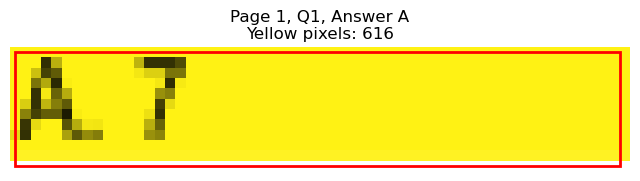

Page 1, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=80.9, y1=114.8
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 42
Page 1, Q1, B: Yellow percentage: 0.0%


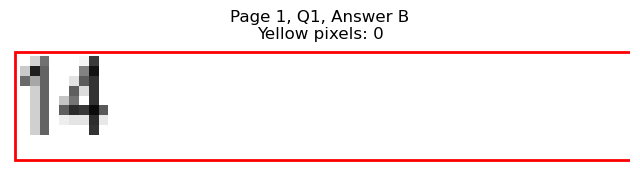

Page 1, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=340.1, y1=102.2
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 39
Page 1, Q1, C: Yellow percentage: 0.0%


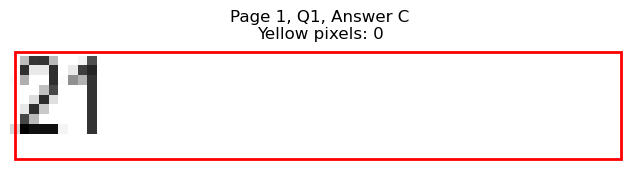

Page 1, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=340.1, y1=114.8
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 60
Page 1, Q1, D: Yellow percentage: 0.0%


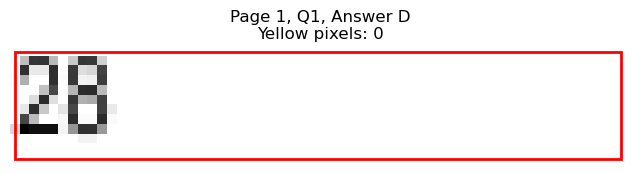


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=149.5, y1=203.1
Page 1, Q2, A: Yellow pixels: 132
Page 1, Q2, A: Total non-white pixels: 692
Page 1, Q2, A: Yellow percentage: 19.1%


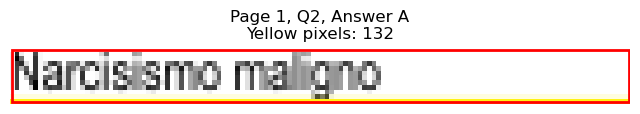

Page 1, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=156.0, y1=215.7
Page 1, Q2, B: Yellow pixels: 1294
Page 1, Q2, B: Total non-white pixels: 1656
Page 1, Q2, B: Yellow percentage: 78.1%


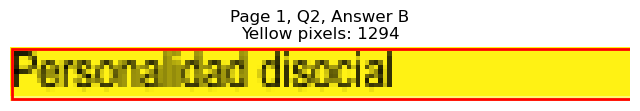

Page 1, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=410.3, y1=203.1
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 447
Page 1, Q2, C: Yellow percentage: 0.0%


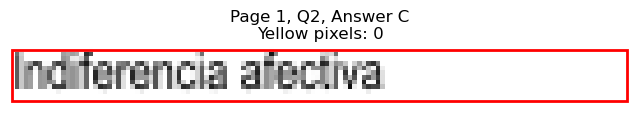

Page 1, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=409.7, y1=215.7
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 406
Page 1, Q2, D: Yellow percentage: 0.0%


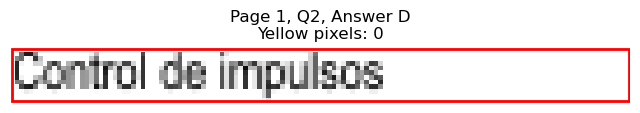


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=115.0, y1=266.2
Page 1, Q3, A: Yellow pixels: 892
Page 1, Q3, A: Total non-white pixels: 1067
Page 1, Q3, A: Yellow percentage: 83.6%


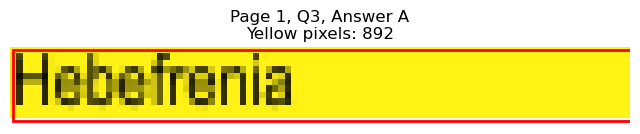

Page 1, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=105.8, y1=278.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 198
Page 1, Q3, B: Yellow percentage: 0.0%


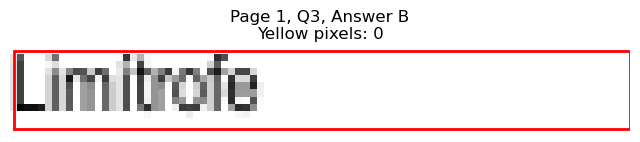

Page 1, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=363.6, y1=266.2
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 184
Page 1, Q3, C: Yellow percentage: 0.0%


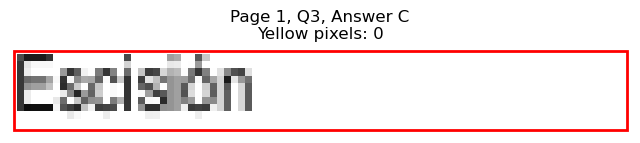

Page 1, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=365.0, y1=278.8
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 201
Page 1, Q3, D: Yellow percentage: 0.0%


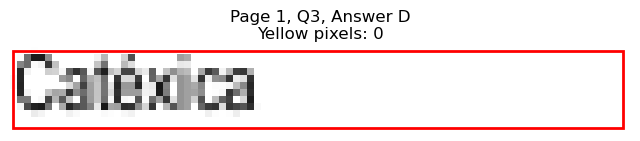


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=107.9, y1=316.8
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 199
Page 1, Q4, A: Yellow percentage: 0.0%


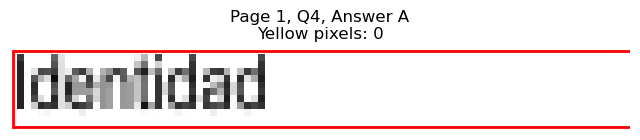

Page 1, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=115.0, y1=329.4
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 246
Page 1, Q4, B: Yellow percentage: 0.0%


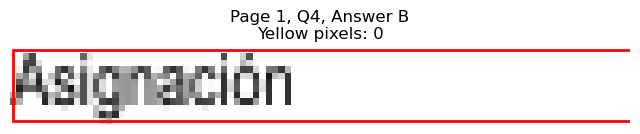

Page 1, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=381.1, y1=316.8
Page 1, Q4, C: Yellow pixels: 105
Page 1, Q4, C: Total non-white pixels: 388
Page 1, Q4, C: Yellow percentage: 27.1%


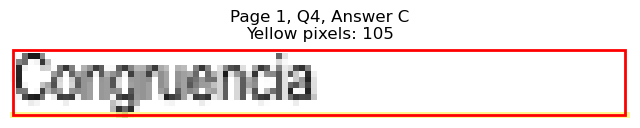

Page 1, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=360.1, y1=329.4
Page 1, Q4, D: Yellow pixels: 809
Page 1, Q4, D: Total non-white pixels: 1008
Page 1, Q4, D: Yellow percentage: 80.3%


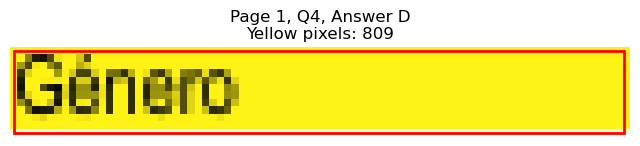


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=133.0, y1=392.5
Page 1, Q5, A: Yellow pixels: 997
Page 1, Q5, A: Total non-white pixels: 1380
Page 1, Q5, A: Yellow percentage: 72.2%


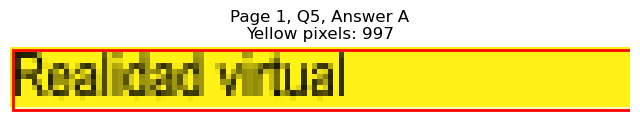

Page 1, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=126.5, y1=405.1
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 297
Page 1, Q5, B: Yellow percentage: 0.0%


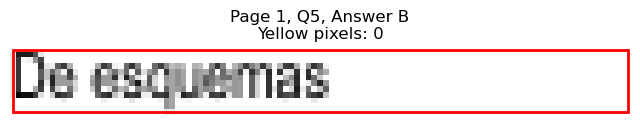

Page 1, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=369.1, y1=392.5
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 223
Page 1, Q5, C: Yellow percentage: 0.0%


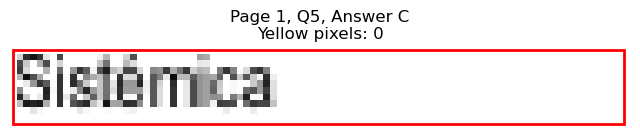

Page 1, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=388.2, y1=405.1
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 318
Page 1, Q5, D: Yellow percentage: 0.0%


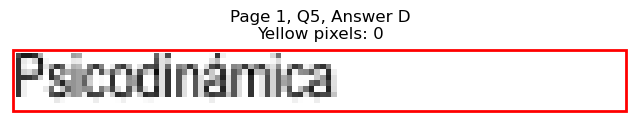


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=98.9, y1=443.0
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 143
Page 1, Q6, A: Yellow percentage: 0.0%


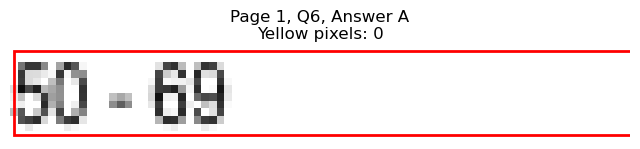

Page 1, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=98.9, y1=455.6
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 133
Page 1, Q6, B: Yellow percentage: 0.0%


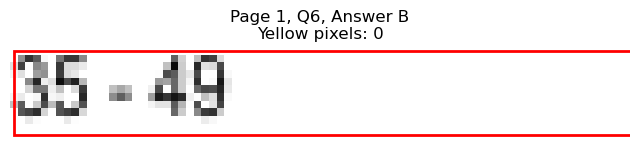

Page 1, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=358.1, y1=443.0
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 192
Page 1, Q6, C: Yellow percentage: 0.0%


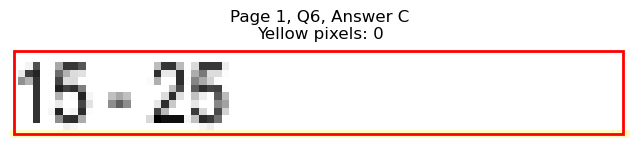

Page 1, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=358.1, y1=455.6
Page 1, Q6, D: Yellow pixels: 815
Page 1, Q6, D: Total non-white pixels: 984
Page 1, Q6, D: Yellow percentage: 82.8%


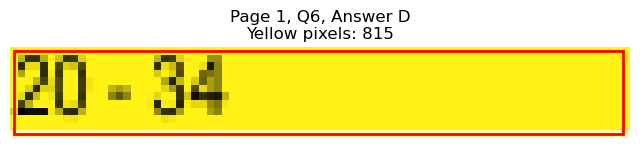


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=482.5, x1=112.0, y1=493.5
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 219
Page 1, Q7, A: Yellow percentage: 0.0%


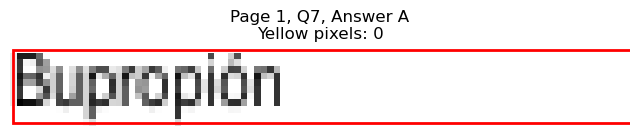

Page 1, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=115.4, y1=506.1
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 242
Page 1, Q7, B: Yellow percentage: 0.0%


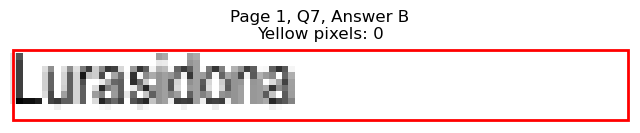

Page 1, Q7 - C: Detected box: x0=327.5, y0=482.5, x1=373.1, y1=493.5
Page 1, Q7, C: Yellow pixels: 907
Page 1, Q7, C: Total non-white pixels: 1164
Page 1, Q7, C: Yellow percentage: 77.9%


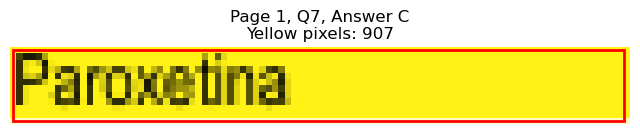

Page 1, Q7 - D: Detected box: x0=327.5, y0=495.1, x1=380.6, y1=506.1
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 273
Page 1, Q7, D: Yellow percentage: 0.0%


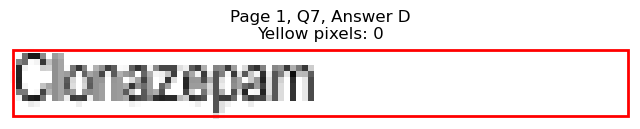


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=153.0, y1=569.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 425
Page 1, Q8, A: Yellow percentage: 0.0%


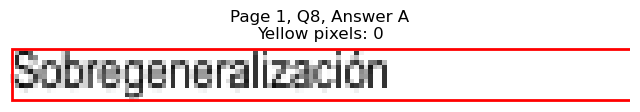

Page 1, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=130.0, y1=581.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 280
Page 1, Q8, B: Yellow percentage: 0.0%


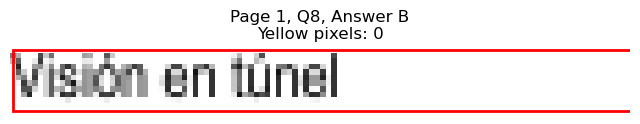

Page 1, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=379.7, y1=569.2
Page 1, Q8, C: Yellow pixels: 927
Page 1, Q8, C: Total non-white pixels: 1133
Page 1, Q8, C: Yellow percentage: 81.8%


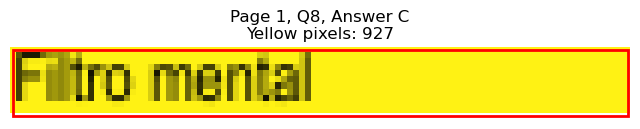

Page 1, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=394.7, y1=581.8
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 362
Page 1, Q8, D: Yellow percentage: 0.0%


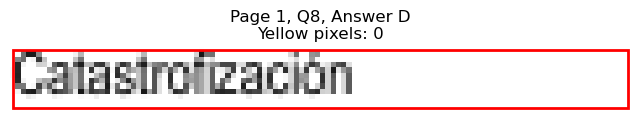


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=646.5, x1=108.4, y1=657.6
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 202
Page 1, Q9, A: Yellow percentage: 0.0%


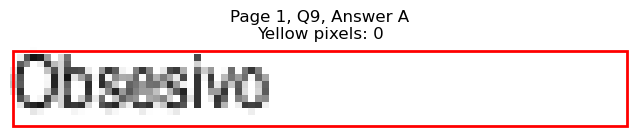

Page 1, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=102.5, y1=670.2
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 183
Page 1, Q9, B: Yellow percentage: 0.0%


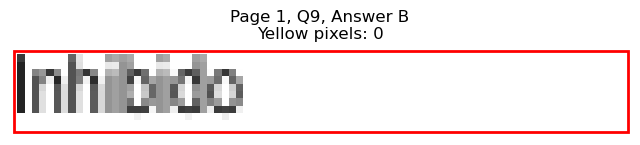

Page 1, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=381.1, y1=657.6
Page 1, Q9, C: Yellow pixels: 925
Page 1, Q9, C: Total non-white pixels: 1260
Page 1, Q9, C: Yellow percentage: 73.4%


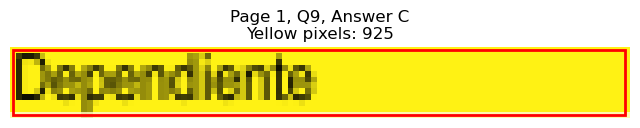

Page 1, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=357.1, y1=670.2
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 144
Page 1, Q9, D: Yellow percentage: 0.0%


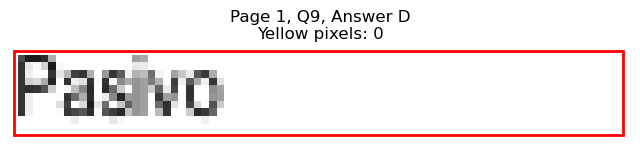


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=722.2, x1=105.8, y1=733.3
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 190
Page 1, Q10, A: Yellow percentage: 0.0%


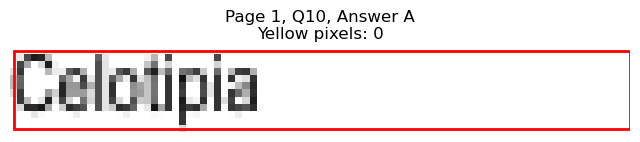

Page 1, Q10 - B: Detected box: x0=68.3, y0=734.8, x1=123.5, y1=745.9
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 264
Page 1, Q10, B: Yellow percentage: 0.0%


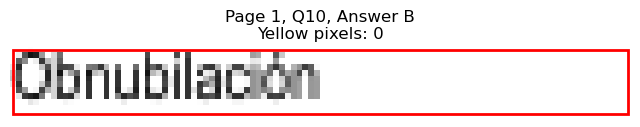

Page 1, Q10 - C: Detected box: x0=327.5, y0=722.2, x1=376.7, y1=733.3
Page 1, Q10, C: Yellow pixels: 921
Page 1, Q10, C: Total non-white pixels: 1200
Page 1, Q10, C: Yellow percentage: 76.8%


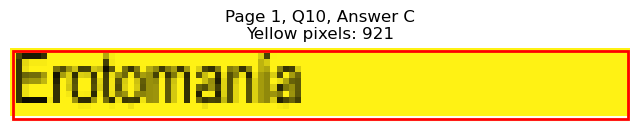

Page 1, Q10 - D: Detected box: x0=327.5, y0=734.8, x1=358.7, y1=745.9
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 183
Page 1, Q10, D: Yellow percentage: 0.0%


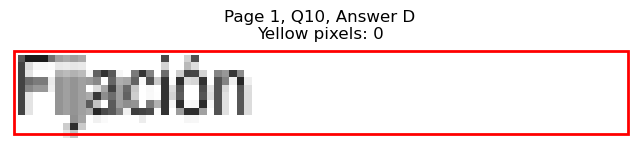


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=98.4, y1=140.0
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 158
Page 2, Q1, A: Yellow percentage: 0.0%


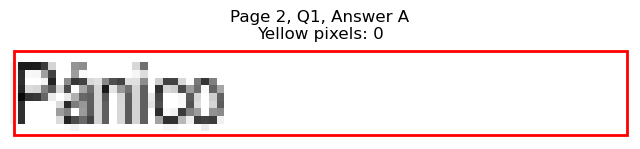

Page 2, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=112.0, y1=152.7
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 223
Page 2, Q1, B: Yellow percentage: 0.0%


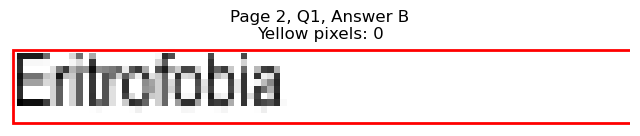

Page 2, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=378.1, y1=140.0
Page 2, Q1, C: Yellow pixels: 1032
Page 2, Q1, C: Total non-white pixels: 1224
Page 2, Q1, C: Yellow percentage: 84.3%


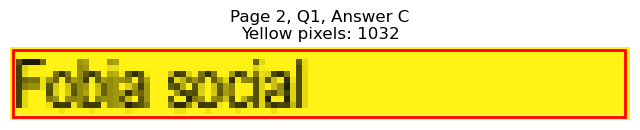

Page 2, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=375.1, y1=152.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 249
Page 2, Q1, D: Yellow percentage: 0.0%


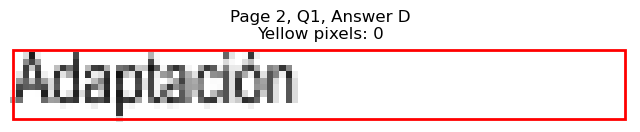


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=118.4, y1=203.1
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 250
Page 2, Q2, A: Yellow percentage: 0.0%


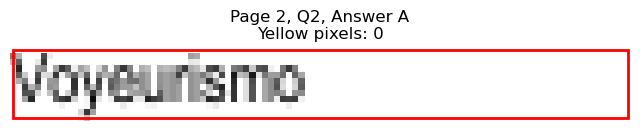

Page 2, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=134.5, y1=215.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 348
Page 2, Q2, B: Yellow percentage: 0.0%


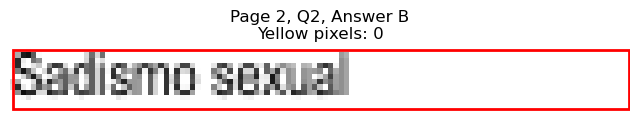

Page 2, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=379.1, y1=203.1
Page 2, Q2, C: Yellow pixels: 943
Page 2, Q2, C: Total non-white pixels: 1133
Page 2, Q2, C: Yellow percentage: 83.2%


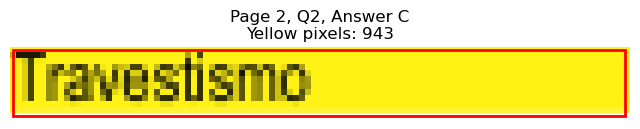

Page 2, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=368.2, y1=215.7
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 218
Page 2, Q2, D: Yellow percentage: 0.0%


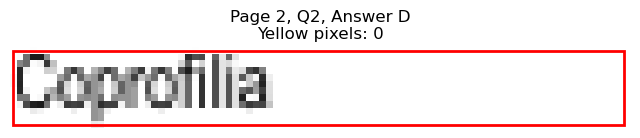


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=123.0, y1=253.6
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 290
Page 2, Q3, A: Yellow percentage: 0.0%


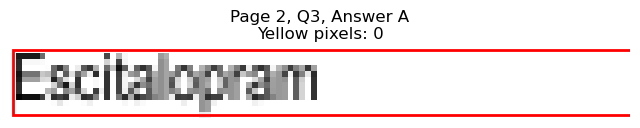

Page 2, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=109.6, y1=266.2
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 223
Page 2, Q3, B: Yellow percentage: 0.0%


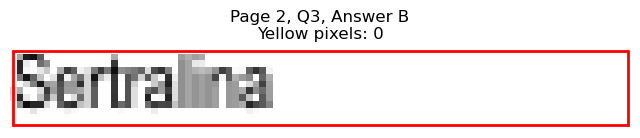

Page 2, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=381.1, y1=253.6
Page 2, Q3, C: Yellow pixels: 105
Page 2, Q3, C: Total non-white pixels: 378
Page 2, Q3, C: Yellow percentage: 27.8%


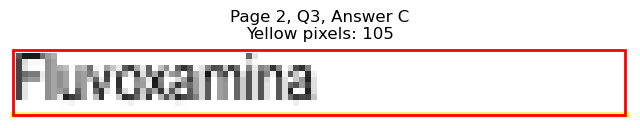

Page 2, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=373.1, y1=266.2
Page 2, Q3, D: Yellow pixels: 907
Page 2, Q3, D: Total non-white pixels: 1067
Page 2, Q3, D: Yellow percentage: 85.0%


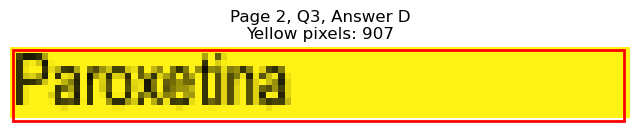


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=159.6, y1=329.4
Page 2, Q4, A: Yellow pixels: 1187
Page 2, Q4, A: Total non-white pixels: 1704
Page 2, Q4, A: Yellow percentage: 69.7%


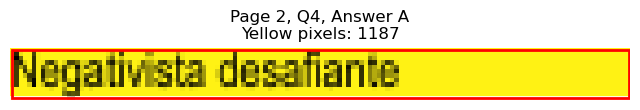

Page 2, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=109.4, y1=342.0
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 211
Page 2, Q4, B: Yellow percentage: 0.0%


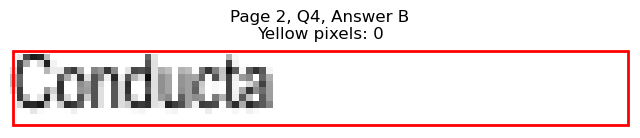

Page 2, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=404.3, y1=329.4
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 400
Page 2, Q4, C: Yellow percentage: 0.0%


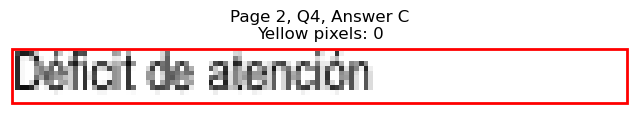

Page 2, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=381.6, y1=342.0
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 258
Page 2, Q4, D: Yellow percentage: 0.0%


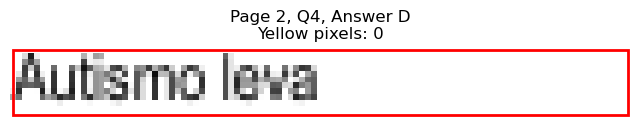


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=134.5, y1=392.5
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 347
Page 2, Q5, A: Yellow percentage: 0.0%


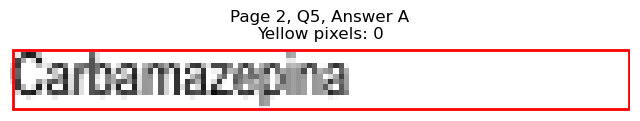

Page 2, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=132.0, y1=405.1
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 335
Page 2, Q5, B: Yellow percentage: 0.0%


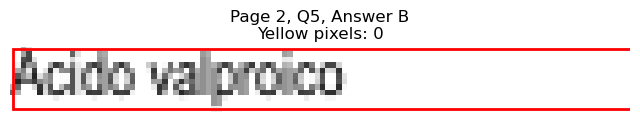

Page 2, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=373.7, y1=392.5
Page 2, Q5, C: Yellow pixels: 97
Page 2, Q5, C: Total non-white pixels: 349
Page 2, Q5, C: Yellow percentage: 27.8%


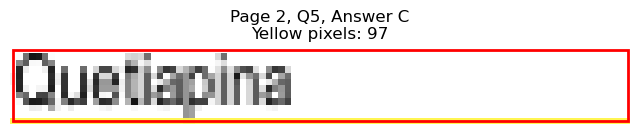

Page 2, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=346.6, y1=405.1
Page 2, Q5, D: Yellow pixels: 706
Page 2, Q5, D: Total non-white pixels: 770
Page 2, Q5, D: Yellow percentage: 91.7%


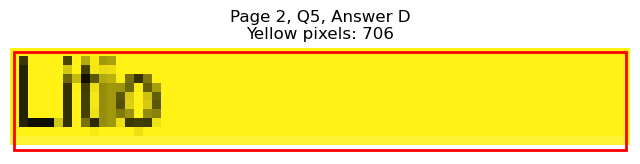


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=124.0, y1=468.2
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 285
Page 2, Q6, A: Yellow percentage: 0.0%


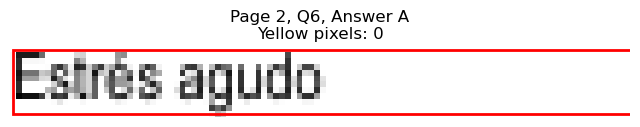

Page 2, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=162.6, y1=480.8
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 497
Page 2, Q6, B: Yellow percentage: 0.0%


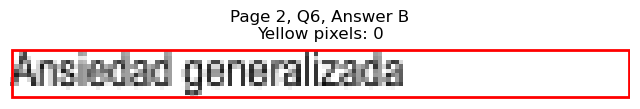

Page 2, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=414.7, y1=468.2
Page 2, Q6, C: Yellow pixels: 1190
Page 2, Q6, C: Total non-white pixels: 1520
Page 2, Q6, C: Yellow percentage: 78.3%


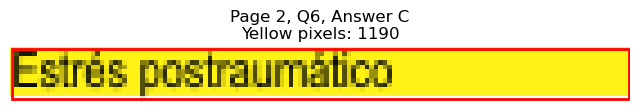

Page 2, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=400.7, y1=480.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 371
Page 2, Q6, D: Yellow percentage: 0.0%


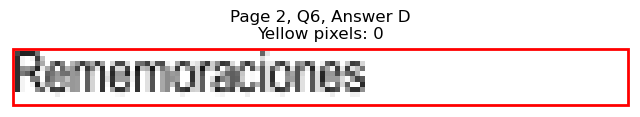


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=245.9, y1=543.9
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 934
Page 2, Q7, A: Yellow percentage: 0.0%


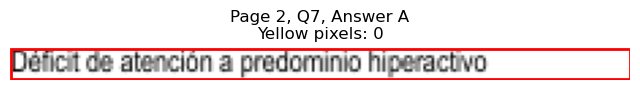

Page 2, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=169.1, y1=556.5
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 521
Page 2, Q7, B: Yellow percentage: 0.0%


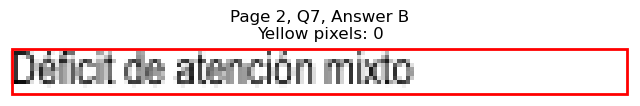

Page 2, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=493.6, y1=543.9
Page 2, Q7, C: Yellow pixels: 1913
Page 2, Q7, C: Total non-white pixels: 2556
Page 2, Q7, C: Yellow percentage: 74.8%


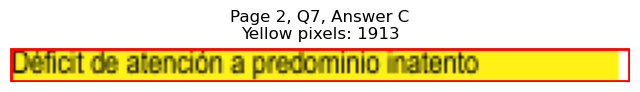

Page 2, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=499.9, y1=556.5
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 865
Page 2, Q7, D: Yellow percentage: 0.0%


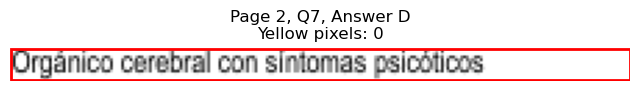


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=118.4, y1=594.4
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 254
Page 2, Q8, A: Yellow percentage: 0.0%


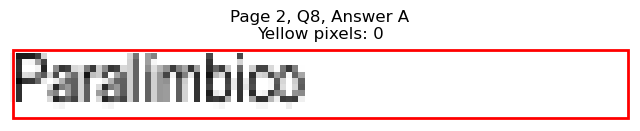

Page 2, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=119.4, y1=607.0
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 264
Page 2, Q8, B: Yellow percentage: 0.0%


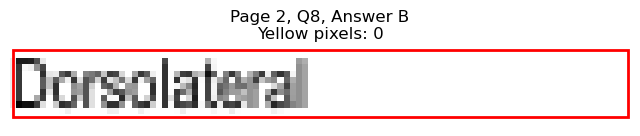

Page 2, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=429.2, y1=594.4
Page 2, Q8, C: Yellow pixels: 1309
Page 2, Q8, C: Total non-white pixels: 1836
Page 2, Q8, C: Yellow percentage: 71.3%


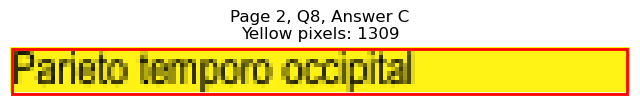

Page 2, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=446.4, y1=607.0
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 640
Page 2, Q8, D: Yellow percentage: 0.0%


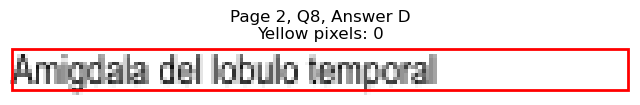


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=112.9, y1=645.0
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 324
Page 2, Q9, A: Yellow percentage: 0.0%


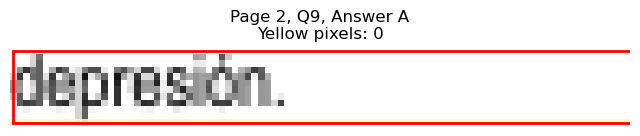

Page 2, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=121.0, y1=657.6
Page 2, Q9, B: Yellow pixels: 917
Page 2, Q9, B: Total non-white pixels: 1236
Page 2, Q9, B: Yellow percentage: 74.2%


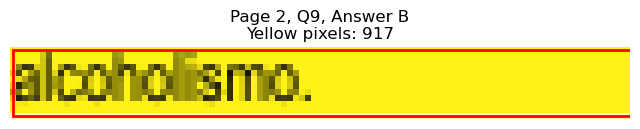

Page 2, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=359.0, y1=645.0
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 128
Page 2, Q9, C: Yellow percentage: 0.0%


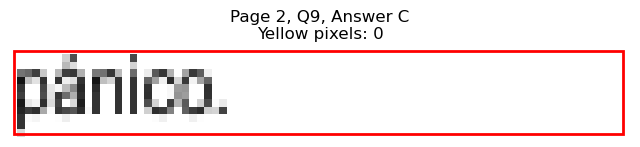

Page 2, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=386.2, y1=657.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 312
Page 2, Q9, D: Yellow percentage: 0.0%


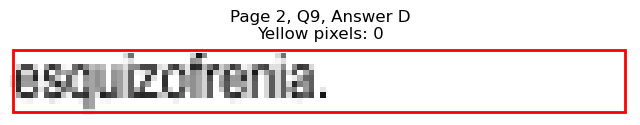


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=734.8, x1=178.7, y1=745.9
Page 2, Q10, A: Yellow pixels: 1466
Page 2, Q10, A: Total non-white pixels: 1932
Page 2, Q10, A: Yellow percentage: 75.9%


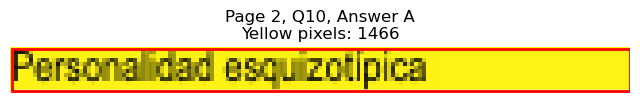

Page 2, Q10 - B: Detected box: x0=68.3, y0=747.4, x1=160.1, y1=758.5
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 447
Page 2, Q10, B: Yellow percentage: 0.0%


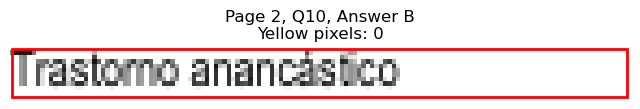

Page 2, Q10 - C: Detected box: x0=327.5, y0=734.8, x1=393.7, y1=745.9
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 354
Page 2, Q10, C: Yellow percentage: 0.0%


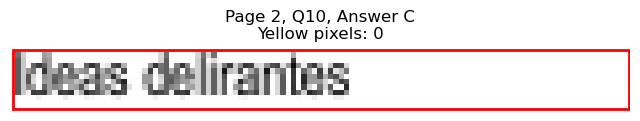

Page 2, Q10 - D: Detected box: x0=327.5, y0=747.4, x1=402.2, y1=758.5
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 395
Page 2, Q10, D: Yellow percentage: 0.0%


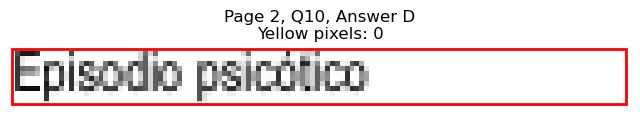


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=162.6, y1=114.8
Page 3, Q1, A: Yellow pixels: 145
Page 3, Q1, A: Total non-white pixels: 650
Page 3, Q1, A: Yellow percentage: 22.3%


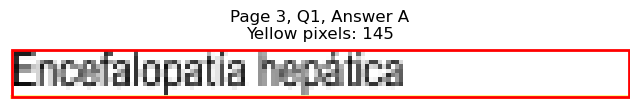

Page 3, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=176.6, y1=127.4
Page 3, Q1, B: Yellow pixels: 1310
Page 3, Q1, B: Total non-white pixels: 1908
Page 3, Q1, B: Yellow percentage: 68.7%


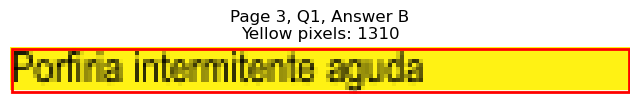

Page 3, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=359.0, y1=114.8
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 148
Page 3, Q1, C: Yellow percentage: 0.0%


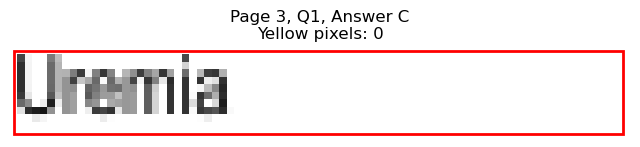

Page 3, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=365.6, y1=127.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 212
Page 3, Q1, D: Yellow percentage: 0.0%


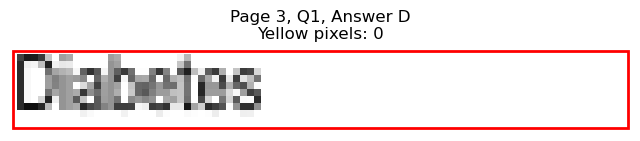


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=115.4, y1=177.9
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 251
Page 3, Q2, A: Yellow percentage: 0.0%


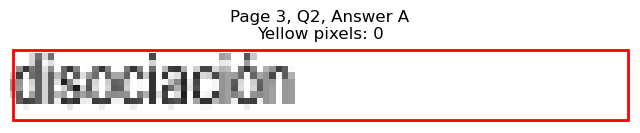

Page 3, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=103.9, y1=190.5
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 195
Page 3, Q2, B: Yellow percentage: 0.0%


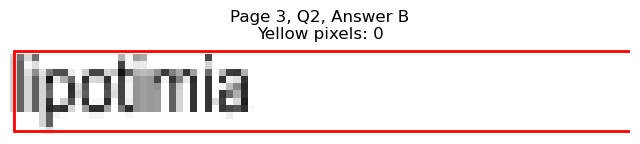

Page 3, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=370.7, y1=177.9
Page 3, Q2, C: Yellow pixels: 959
Page 3, Q2, C: Total non-white pixels: 1128
Page 3, Q2, C: Yellow percentage: 85.0%


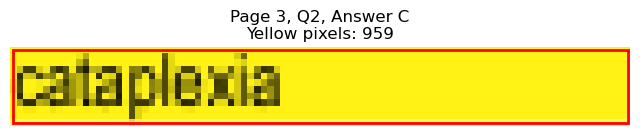

Page 3, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=376.2, y1=190.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 249
Page 3, Q2, D: Yellow percentage: 0.0%


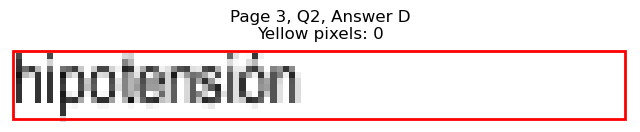


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=113.9, y1=253.6
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 255
Page 3, Q3, A: Yellow percentage: 0.0%


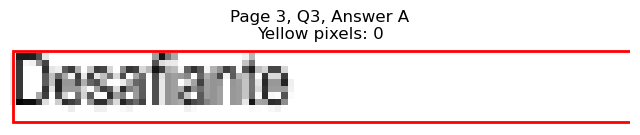

Page 3, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=145.1, y1=266.2
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 408
Page 3, Q3, B: Yellow percentage: 0.0%


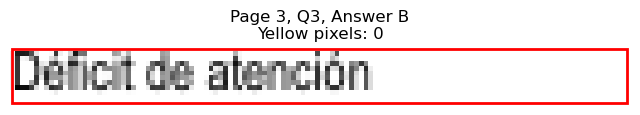

Page 3, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=363.6, y1=253.6
Page 3, Q3, C: Yellow pixels: 87
Page 3, Q3, C: Total non-white pixels: 282
Page 3, Q3, C: Yellow percentage: 30.9%


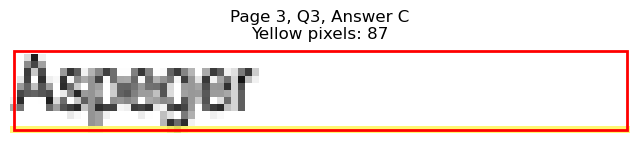

Page 3, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=368.6, y1=266.2
Page 3, Q3, D: Yellow pixels: 840
Page 3, Q3, D: Total non-white pixels: 1012
Page 3, Q3, D: Yellow percentage: 83.0%


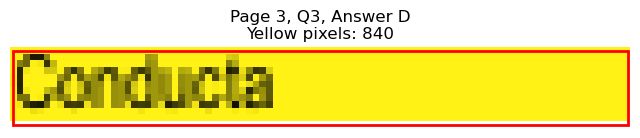


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=112.0, y1=304.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 225
Page 3, Q4, A: Yellow percentage: 0.0%


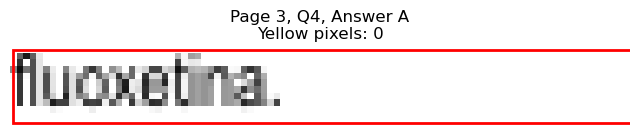

Page 3, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=115.4, y1=316.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 223
Page 3, Q4, B: Yellow percentage: 0.0%


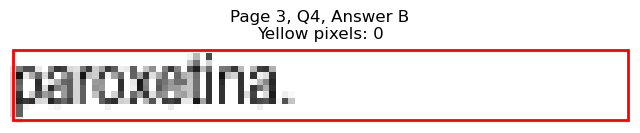

Page 3, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=370.7, y1=304.2
Page 3, Q4, C: Yellow pixels: 886
Page 3, Q4, C: Total non-white pixels: 1035
Page 3, Q4, C: Yellow percentage: 85.6%


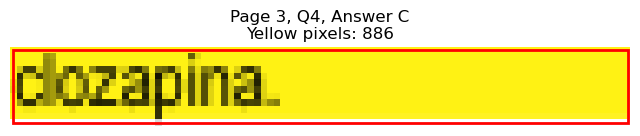

Page 3, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=380.6, y1=316.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 267
Page 3, Q4, D: Yellow percentage: 0.0%


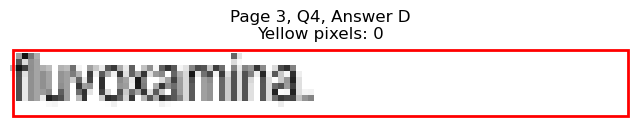


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=120.0, y1=354.7
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 277
Page 3, Q5, A: Yellow percentage: 0.0%


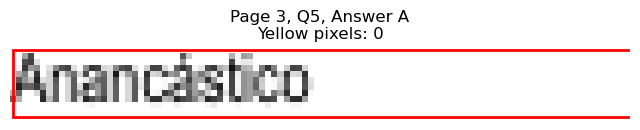

Page 3, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=103.4, y1=367.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 197
Page 3, Q5, B: Yellow percentage: 0.0%


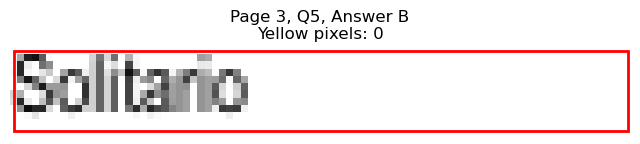

Page 3, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=371.2, y1=354.7
Page 3, Q5, C: Yellow pixels: 95
Page 3, Q5, C: Total non-white pixels: 309
Page 3, Q5, C: Yellow percentage: 30.7%


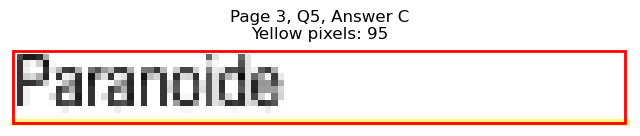

Page 3, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=364.1, y1=367.3
Page 3, Q5, D: Yellow pixels: 820
Page 3, Q5, D: Total non-white pixels: 1056
Page 3, Q5, D: Yellow percentage: 77.7%


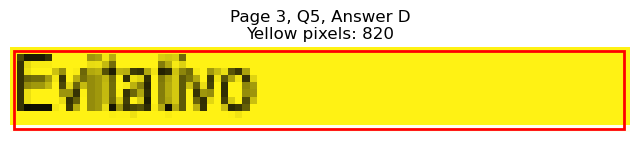


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=174.6, y1=417.7
Page 3, Q6, A: Yellow pixels: 1473
Page 3, Q6, A: Total non-white pixels: 1884
Page 3, Q6, A: Yellow percentage: 78.2%


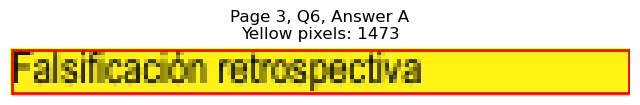

Page 3, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=157.6, y1=430.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 497
Page 3, Q6, B: Yellow percentage: 0.0%


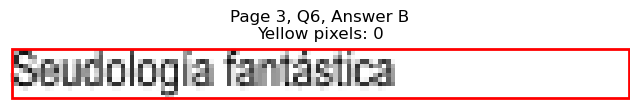

Page 3, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=415.8, y1=417.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 458
Page 3, Q6, C: Yellow percentage: 0.0%


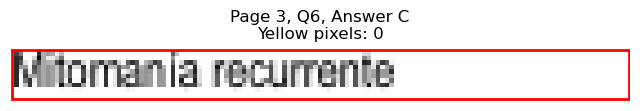

Page 3, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=422.8, y1=430.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 501
Page 3, Q6, D: Yellow percentage: 0.0%


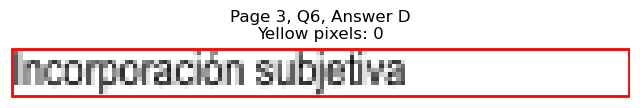


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=457.2, x1=113.4, y1=468.2
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 255
Page 3, Q7, A: Yellow percentage: 0.0%


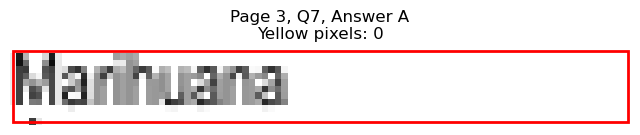

Page 3, Q7 - B: Detected box: x0=68.3, y0=469.8, x1=99.8, y1=480.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 172
Page 3, Q7, B: Yellow percentage: 0.0%


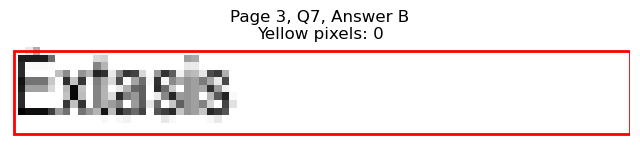

Page 3, Q7 - C: Detected box: x0=327.5, y0=457.2, x1=362.0, y1=468.2
Page 3, Q7, C: Yellow pixels: 817
Page 3, Q7, C: Total non-white pixels: 946
Page 3, Q7, C: Yellow percentage: 86.4%


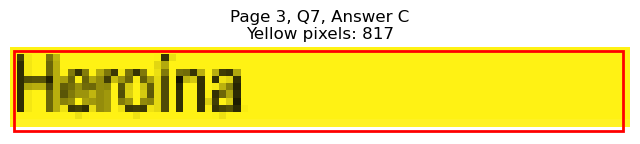

Page 3, Q7 - D: Detected box: x0=327.5, y0=469.8, x1=375.1, y1=480.8
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 231
Page 3, Q7, D: Yellow percentage: 0.0%


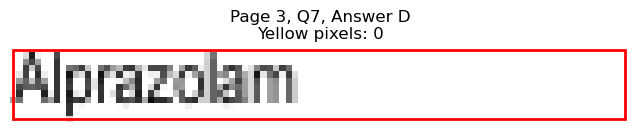


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=520.3, x1=103.4, y1=531.3
Page 3, Q8, A: Yellow pixels: 86
Page 3, Q8, A: Total non-white pixels: 257
Page 3, Q8, A: Yellow percentage: 33.5%


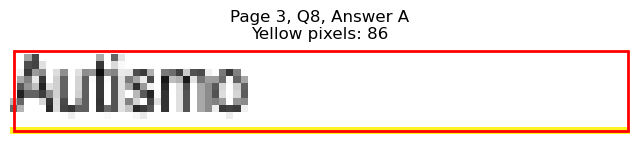

Page 3, Q8 - B: Detected box: x0=68.3, y0=532.9, x1=115.9, y1=543.9
Page 3, Q8, B: Yellow pixels: 992
Page 3, Q8, B: Total non-white pixels: 1176
Page 3, Q8, B: Yellow percentage: 84.4%


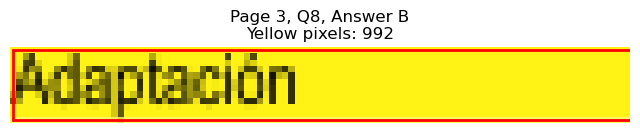

Page 3, Q8 - C: Detected box: x0=327.5, y0=520.3, x1=391.7, y1=531.3
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 336
Page 3, Q8, C: Yellow percentage: 0.0%


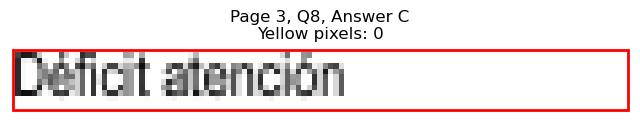

Page 3, Q8 - D: Detected box: x0=327.5, y0=532.9, x1=384.7, y1=543.9
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 317
Page 3, Q8, D: Yellow percentage: 0.0%


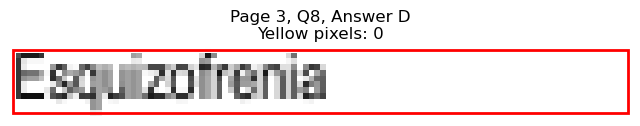


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=116.4, y1=619.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 270
Page 3, Q9, A: Yellow percentage: 0.0%


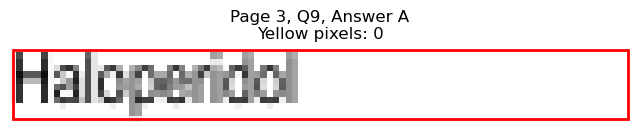

Page 3, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=118.9, y1=632.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 256
Page 3, Q9, B: Yellow percentage: 0.0%


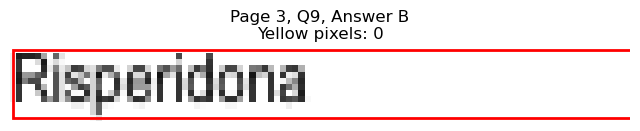

Page 3, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=373.7, y1=619.6
Page 3, Q9, C: Yellow pixels: 97
Page 3, Q9, C: Total non-white pixels: 349
Page 3, Q9, C: Yellow percentage: 27.8%


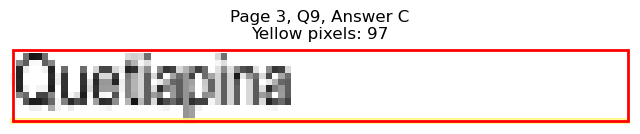

Page 3, Q9 - D: Detected box: x0=327.5, y0=469.8, x1=375.1, y1=480.8
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 231
Page 3, Q9, D: Yellow percentage: 0.0%


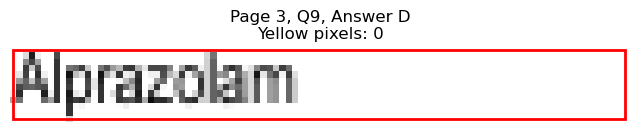


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=106.4, y1=682.8
Page 3, Q10, A: Yellow pixels: 901
Page 3, Q10, A: Total non-white pixels: 1068
Page 3, Q10, A: Yellow percentage: 84.4%


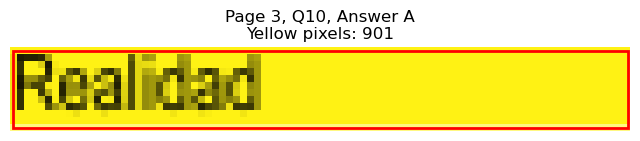

Page 3, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=126.0, y1=695.4
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 288
Page 3, Q10, B: Yellow percentage: 0.0%


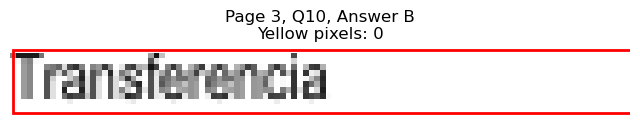

Page 3, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=363.6, y1=682.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 190
Page 3, Q10, C: Yellow percentage: 0.0%


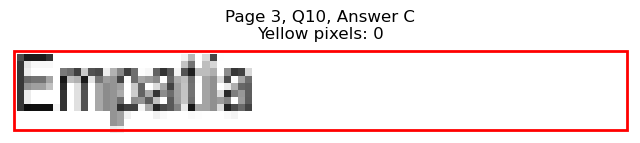

Page 3, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=374.6, y1=695.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 252
Page 3, Q10, D: Yellow percentage: 0.0%


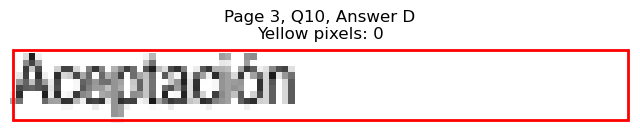


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=113.9, y1=745.9
Page 3, Q11, A: Yellow pixels: 971
Page 3, Q11, A: Total non-white pixels: 1152
Page 3, Q11, A: Yellow percentage: 84.3%


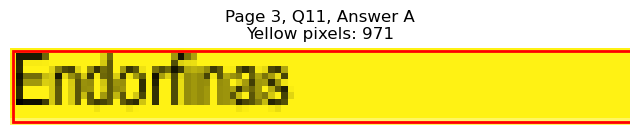

Page 3, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=112.4, y1=758.5
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 225
Page 3, Q11, B: Yellow percentage: 0.0%


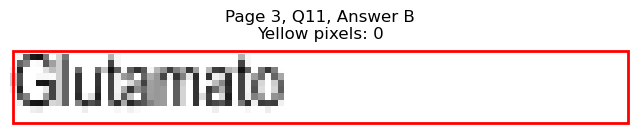

Page 3, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=373.7, y1=745.9
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 242
Page 3, Q11, C: Yellow percentage: 0.0%


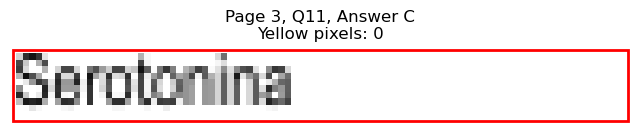

Page 3, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=360.6, y1=758.5
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 168
Page 3, Q11, D: Yellow percentage: 0.0%


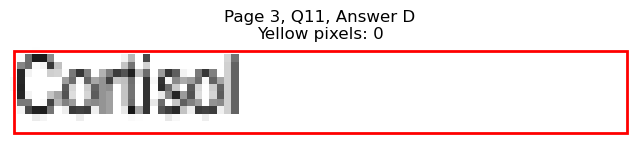


Page 3, Q11 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=113.9, y1=114.8
Page 4, Q1, A: Yellow pixels: 96
Page 4, Q1, A: Total non-white pixels: 315
Page 4, Q1, A: Yellow percentage: 30.5%


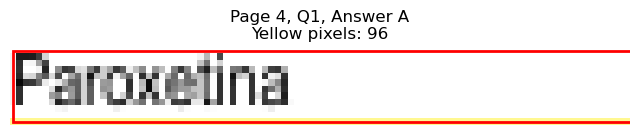

Page 4, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=117.5, y1=127.4
Page 4, Q1, B: Yellow pixels: 881
Page 4, Q1, B: Total non-white pixels: 1200
Page 4, Q1, B: Yellow percentage: 73.4%


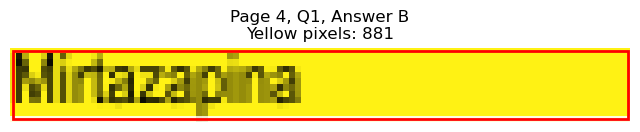

Page 4, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=371.6, y1=114.8
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 234
Page 4, Q1, C: Yellow percentage: 0.0%


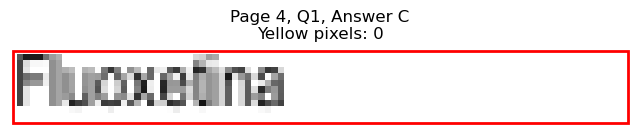

Page 4, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=371.2, y1=127.4
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 214
Page 4, Q1, D: Yellow percentage: 0.0%


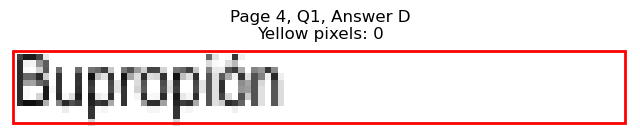


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=117.5, y1=165.3
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 282
Page 4, Q2, A: Yellow percentage: 0.0%


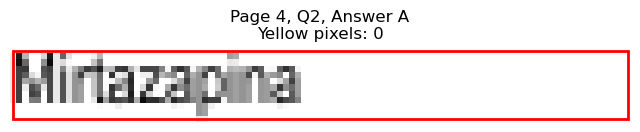

Page 4, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=126.5, y1=177.9
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 284
Page 4, Q2, B: Yellow percentage: 0.0%


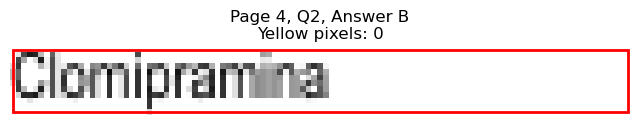

Page 4, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=373.1, y1=165.3
Page 4, Q2, C: Yellow pixels: 97
Page 4, Q2, C: Total non-white pixels: 314
Page 4, Q2, C: Yellow percentage: 30.9%


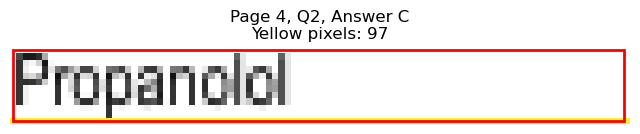

Page 4, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=371.6, y1=177.9
Page 4, Q2, D: Yellow pixels: 960
Page 4, Q2, D: Total non-white pixels: 1140
Page 4, Q2, D: Yellow percentage: 84.2%


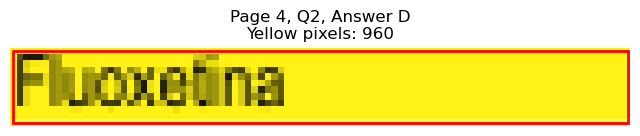


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=120.5, y1=215.7
Page 4, Q3, A: Yellow pixels: 1003
Page 4, Q3, A: Total non-white pixels: 1236
Page 4, Q3, A: Yellow percentage: 81.1%


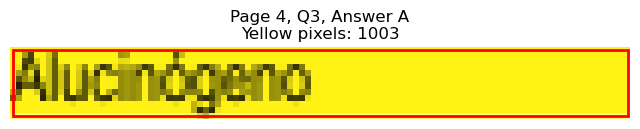

Page 4, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=125.5, y1=228.4
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 300
Page 4, Q3, B: Yellow percentage: 0.0%


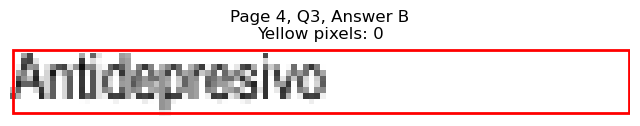

Page 4, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=369.6, y1=215.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 207
Page 4, Q3, C: Yellow percentage: 0.0%


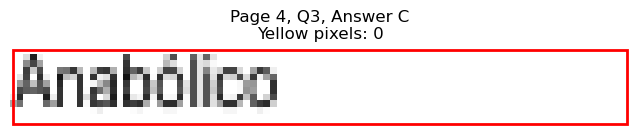

Page 4, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=380.6, y1=228.4
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 277
Page 4, Q3, D: Yellow percentage: 0.0%


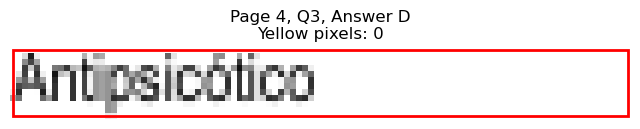


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=187.2, y1=266.2
Page 4, Q4, A: Yellow pixels: 1406
Page 4, Q4, A: Total non-white pixels: 1870
Page 4, Q4, A: Yellow percentage: 75.2%


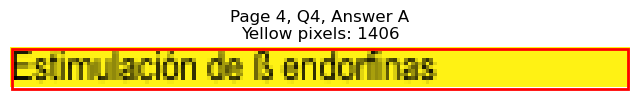

Page 4, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=165.6, y1=278.8
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 499
Page 4, Q4, B: Yellow percentage: 0.0%


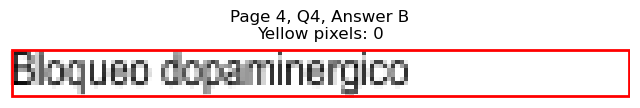

Page 4, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=417.7, y1=266.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 488
Page 4, Q4, C: Yellow percentage: 0.0%


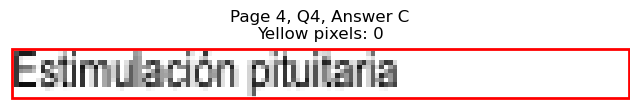

Page 4, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=424.8, y1=278.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 500
Page 4, Q4, D: Yellow percentage: 0.0%


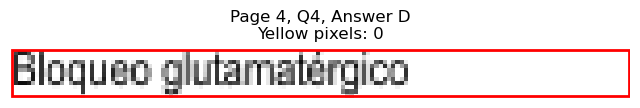


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=118.0, y1=354.7
Page 4, Q5, A: Yellow pixels: 100
Page 4, Q5, A: Total non-white pixels: 337
Page 4, Q5, A: Yellow percentage: 29.7%


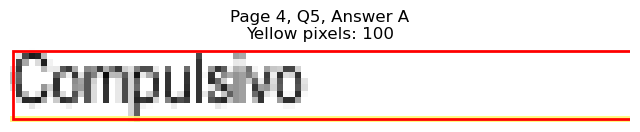

Page 4, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=122.4, y1=367.3
Page 4, Q5, B: Yellow pixels: 954
Page 4, Q5, B: Total non-white pixels: 1260
Page 4, Q5, B: Yellow percentage: 75.7%


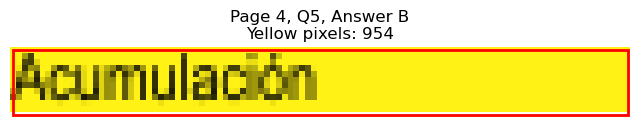

Page 4, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=382.2, y1=354.7
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 295
Page 4, Q5, C: Yellow percentage: 0.0%


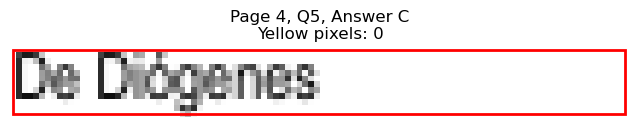

Page 4, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=364.1, y1=367.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 191
Page 4, Q5, D: Yellow percentage: 0.0%


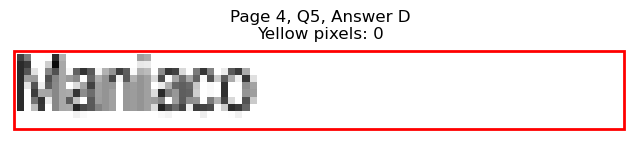


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=141.5, y1=417.7
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 375
Page 4, Q6, A: Yellow percentage: 0.0%


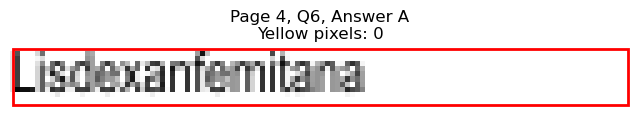

Page 4, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=108.4, y1=430.4
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 218
Page 4, Q6, B: Yellow percentage: 0.0%


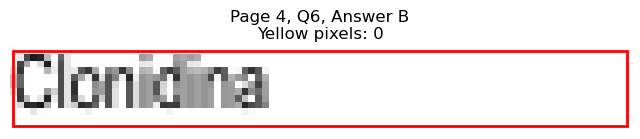

Page 4, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=401.2, y1=417.7
Page 4, Q6, C: Yellow pixels: 1208
Page 4, Q6, C: Total non-white pixels: 1500
Page 4, Q6, C: Yellow percentage: 80.5%


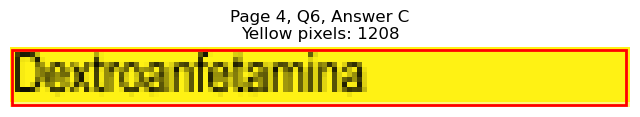

Page 4, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=381.2, y1=430.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 298
Page 4, Q6, D: Yellow percentage: 0.0%


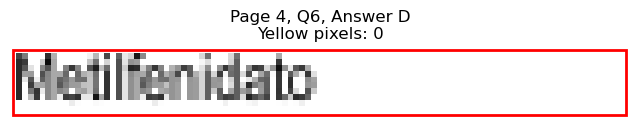


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=457.2, x1=123.0, y1=468.2
Page 4, Q7, A: Yellow pixels: 105
Page 4, Q7, A: Total non-white pixels: 496
Page 4, Q7, A: Yellow percentage: 21.2%


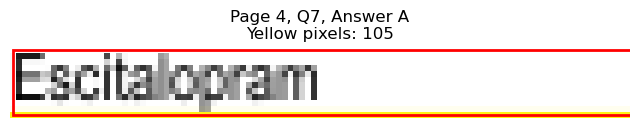

Page 4, Q7 - B: Detected box: x0=68.3, y0=469.8, x1=118.0, y1=480.8
Page 4, Q7, B: Yellow pixels: 1018
Page 4, Q7, B: Total non-white pixels: 1200
Page 4, Q7, B: Yellow percentage: 84.8%


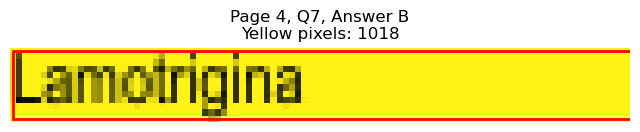

Page 4, Q7 - C: Detected box: x0=327.5, y0=457.2, x1=385.7, y1=468.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 295
Page 4, Q7, C: Yellow percentage: 0.0%


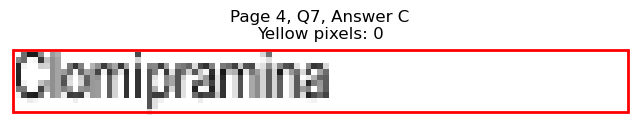

Page 4, Q7 - D: Detected box: x0=327.5, y0=469.8, x1=380.6, y1=480.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 273
Page 4, Q7, D: Yellow percentage: 0.0%


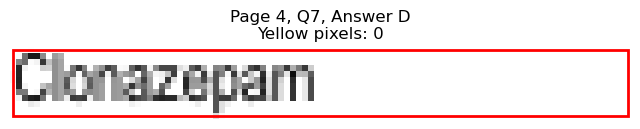


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=174.1, y1=543.9
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 556
Page 4, Q8, A: Yellow percentage: 0.0%


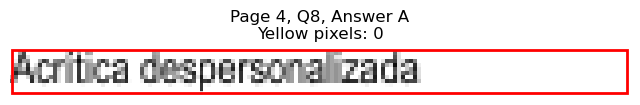

Page 4, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=154.1, y1=556.5
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 425
Page 4, Q8, B: Yellow percentage: 0.0%


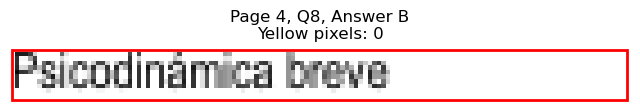

Page 4, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=413.8, y1=543.9
Page 4, Q8, C: Yellow pixels: 1337
Page 4, Q8, C: Total non-white pixels: 1644
Page 4, Q8, C: Yellow percentage: 81.3%


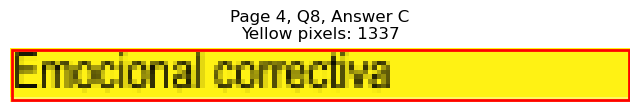

Page 4, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=444.4, y1=556.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 622
Page 4, Q8, D: Yellow percentage: 0.0%


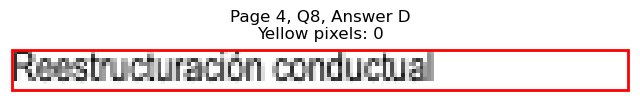


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=132.0, y1=619.6
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 321
Page 4, Q9, A: Yellow percentage: 0.0%


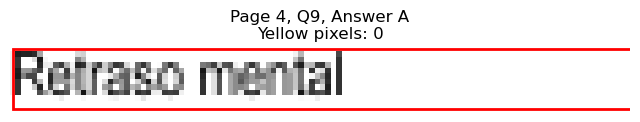

Page 4, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=198.2, y1=632.4
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 713
Page 4, Q9, B: Yellow percentage: 0.0%


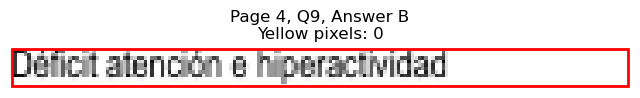

Page 4, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=394.7, y1=619.6
Page 4, Q9, C: Yellow pixels: 1141
Page 4, Q9, C: Total non-white pixels: 1416
Page 4, Q9, C: Yellow percentage: 80.6%


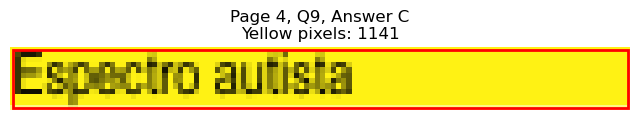

Page 4, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=427.8, y1=632.4
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 541
Page 4, Q9, D: Yellow percentage: 0.0%


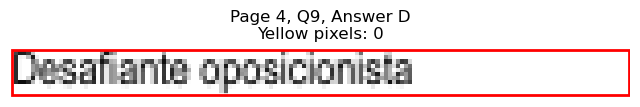


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=103.9, y1=695.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 192
Page 4, Q10, A: Yellow percentage: 0.0%


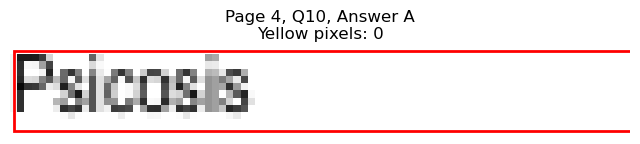

Page 4, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=122.9, y1=708.1
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 266
Page 4, Q10, B: Yellow percentage: 0.0%


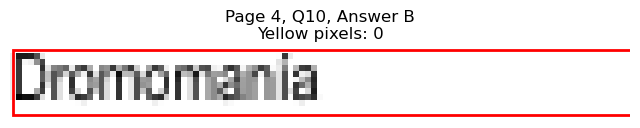

Page 4, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=374.2, y1=695.4
Page 4, Q10, C: Yellow pixels: 98
Page 4, Q10, C: Total non-white pixels: 358
Page 4, Q10, C: Yellow percentage: 27.4%


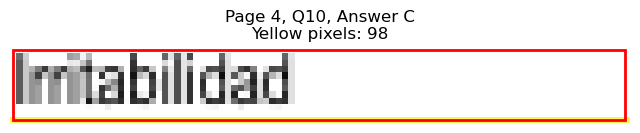

Page 4, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=361.6, y1=708.1
Page 4, Q10, D: Yellow pixels: 792
Page 4, Q10, D: Total non-white pixels: 935
Page 4, Q10, D: Yellow percentage: 84.7%


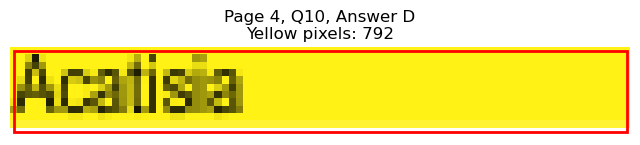


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=747.4, x1=139.4, y1=758.5
Page 4, Q11, A: Yellow pixels: 122
Page 4, Q11, A: Total non-white pixels: 490
Page 4, Q11, A: Yellow percentage: 24.9%


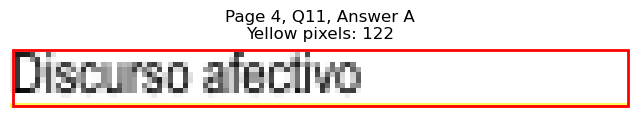

Page 4, Q11 - B: Detected box: x0=68.3, y0=760.2, x1=144.5, y1=771.2
Page 4, Q11, B: Yellow pixels: 1095
Page 4, Q11, B: Total non-white pixels: 1397
Page 4, Q11, B: Yellow percentage: 78.4%


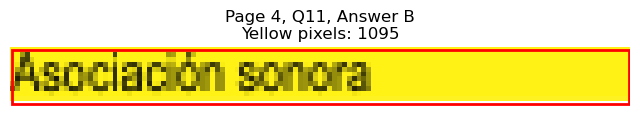

Page 4, Q11 - C: Detected box: x0=327.5, y0=747.4, x1=414.2, y1=758.5
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 465
Page 4, Q11, C: Yellow percentage: 0.0%


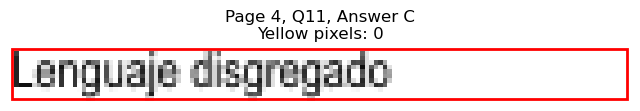

Page 4, Q11 - D: Detected box: x0=327.5, y0=760.2, x1=417.2, y1=771.2
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 468
Page 4, Q11, D: Yellow percentage: 0.0%


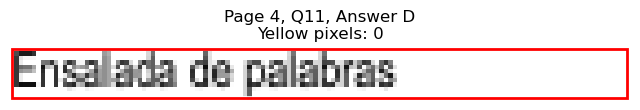


Page 4, Q11 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=119.4, y1=102.2
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 249
Page 5, Q1, A: Yellow percentage: 0.0%


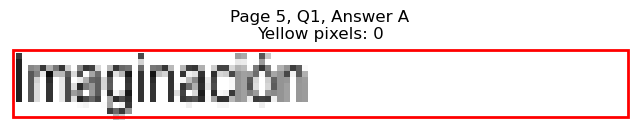

Page 5, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=115.9, y1=114.8
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 240
Page 5, Q1, B: Yellow percentage: 0.0%


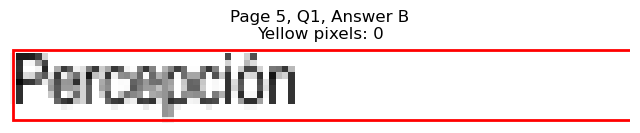

Page 5, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=382.7, y1=102.2
Page 5, Q1, C: Yellow pixels: 957
Page 5, Q1, C: Total non-white pixels: 1166
Page 5, Q1, C: Yellow percentage: 82.1%


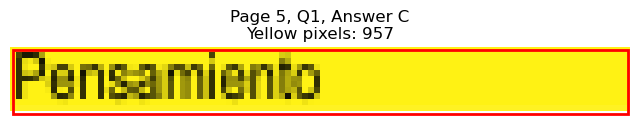

Page 5, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=356.0, y1=114.8
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 145
Page 5, Q1, D: Yellow percentage: 0.0%


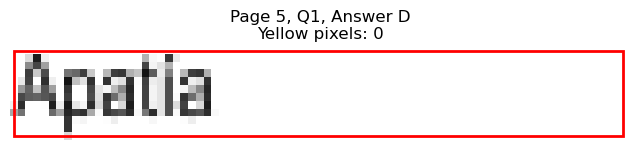


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=96.4, y1=152.7
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 133
Page 5, Q2, A: Yellow percentage: 0.0%


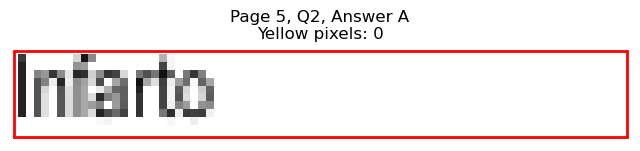

Page 5, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=125.4, y1=165.3
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 330
Page 5, Q2, B: Yellow percentage: 0.0%


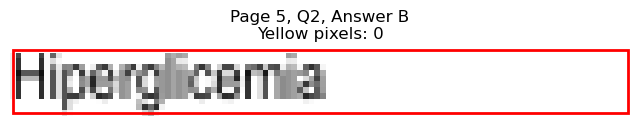

Page 5, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=360.6, y1=152.7
Page 5, Q2, C: Yellow pixels: 84
Page 5, Q2, C: Total non-white pixels: 246
Page 5, Q2, C: Yellow percentage: 34.1%


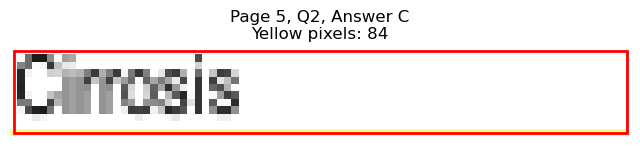

Page 5, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=361.6, y1=165.3
Page 5, Q2, D: Yellow pixels: 801
Page 5, Q2, D: Total non-white pixels: 1020
Page 5, Q2, D: Yellow percentage: 78.5%


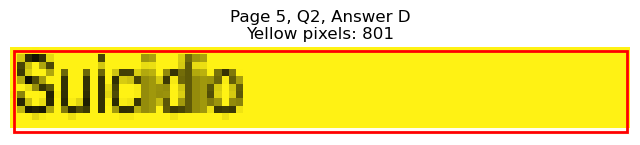


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=109.9, y1=215.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 216
Page 5, Q3, A: Yellow percentage: 0.0%


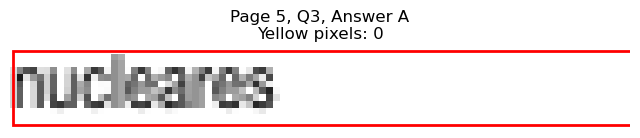

Page 5, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=116.4, y1=228.4
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 267
Page 5, Q3, B: Yellow percentage: 0.0%


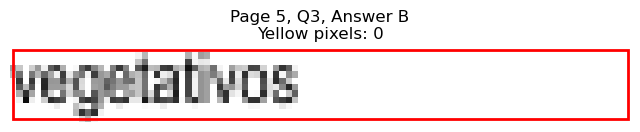

Page 5, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=371.2, y1=215.7
Page 5, Q3, C: Yellow pixels: 955
Page 5, Q3, C: Total non-white pixels: 1140
Page 5, Q3, C: Yellow percentage: 83.8%


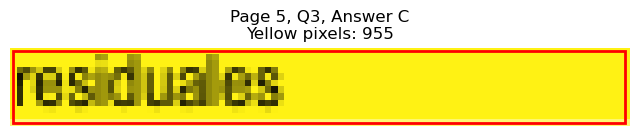

Page 5, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=368.6, y1=228.4
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 189
Page 5, Q3, D: Yellow percentage: 0.0%


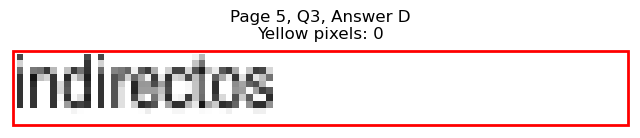


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=134.5, y1=291.6
Page 5, Q4, A: Yellow pixels: 117
Page 5, Q4, A: Total non-white pixels: 452
Page 5, Q4, A: Yellow percentage: 25.9%


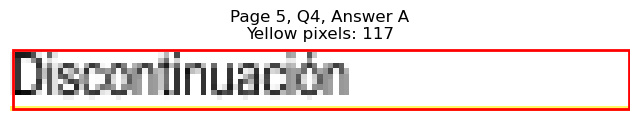

Page 5, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=155.5, y1=304.2
Page 5, Q4, B: Yellow pixels: 1144
Page 5, Q4, B: Total non-white pixels: 1523
Page 5, Q4, B: Yellow percentage: 75.1%


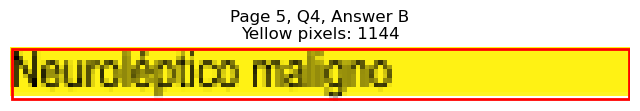

Page 5, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=359.6, y1=291.6
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 148
Page 5, Q4, C: Yellow percentage: 0.0%


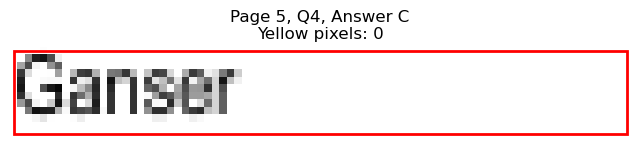

Page 5, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=363.1, y1=304.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 173
Page 5, Q4, D: Yellow percentage: 0.0%


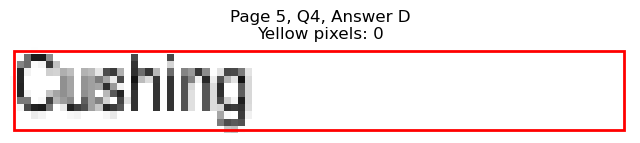


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=94.9, y1=342.0
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 110
Page 5, Q5, A: Yellow percentage: 0.0%


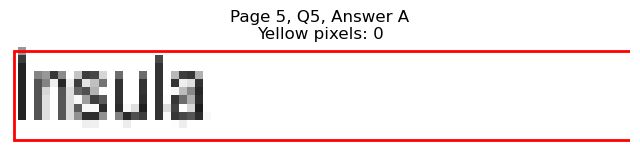

Page 5, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=105.4, y1=354.7
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 195
Page 5, Q5, B: Yellow percentage: 0.0%


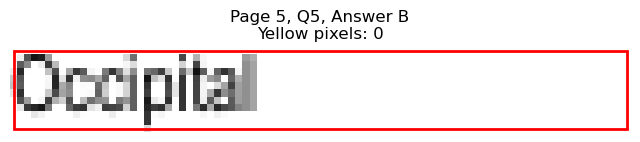

Page 5, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=375.6, y1=342.0
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 346
Page 5, Q5, C: Yellow percentage: 0.0%


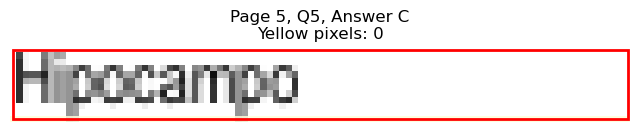

Page 5, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=418.8, y1=354.7
Page 5, Q5, D: Yellow pixels: 1338
Page 5, Q5, D: Total non-white pixels: 1704
Page 5, Q5, D: Yellow percentage: 78.5%


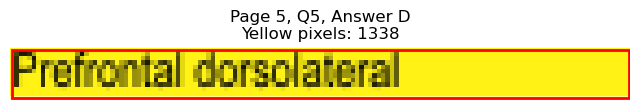


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=117.5, y1=430.4
Page 5, Q6, A: Yellow pixels: 915
Page 5, Q6, A: Total non-white pixels: 1200
Page 5, Q6, A: Yellow percentage: 76.2%


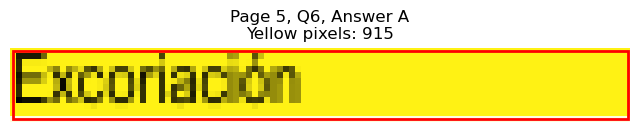

Page 5, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=108.4, y1=443.0
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 202
Page 5, Q6, B: Yellow percentage: 0.0%


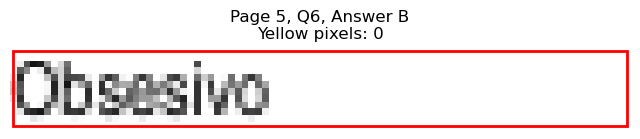

Page 5, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=359.0, y1=430.4
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 141
Page 5, Q6, C: Yellow percentage: 0.0%


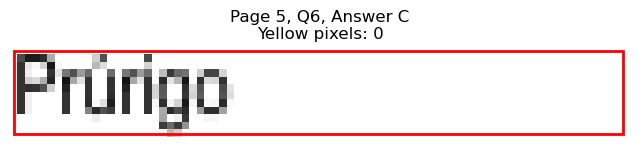

Page 5, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=372.6, y1=443.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 231
Page 5, Q6, D: Yellow percentage: 0.0%


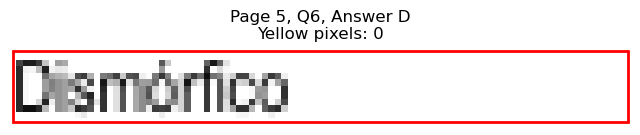


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=482.5, x1=165.1, y1=493.5
Page 5, Q7, A: Yellow pixels: 1264
Page 5, Q7, A: Total non-white pixels: 1776
Page 5, Q7, A: Yellow percentage: 71.2%


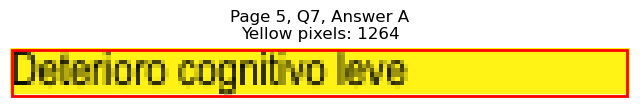

Page 5, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=175.1, y1=506.1
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 530
Page 5, Q7, B: Yellow percentage: 0.0%


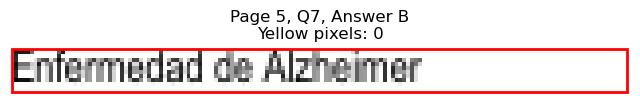

Page 5, Q7 - C: Detected box: x0=327.5, y0=482.5, x1=394.7, y1=493.5
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 326
Page 5, Q7, C: Yellow percentage: 0.0%


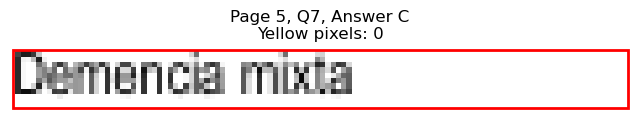

Page 5, Q7 - D: Detected box: x0=327.5, y0=495.1, x1=440.9, y1=506.1
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 547
Page 5, Q7, D: Yellow percentage: 0.0%


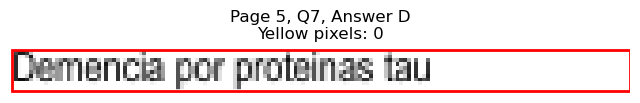


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=137.0, y1=556.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 337
Page 5, Q8, A: Yellow percentage: 0.0%


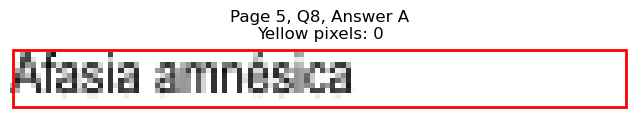

Page 5, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=109.4, y1=569.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 218
Page 5, Q8, B: Yellow percentage: 0.0%


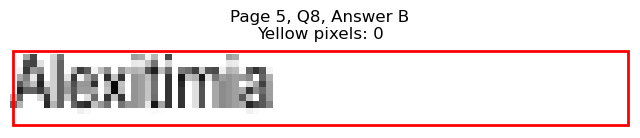

Page 5, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=384.1, y1=556.5
Page 5, Q8, C: Yellow pixels: 953
Page 5, Q8, C: Total non-white pixels: 1296
Page 5, Q8, C: Yellow percentage: 73.5%


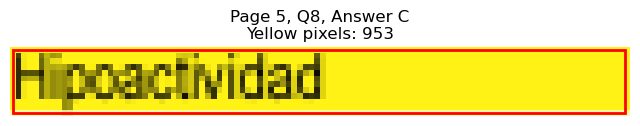

Page 5, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=385.7, y1=569.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 318
Page 5, Q8, D: Yellow percentage: 0.0%


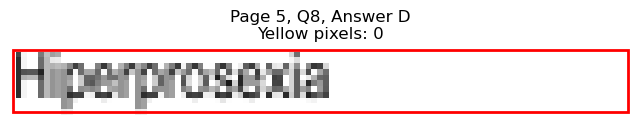


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=112.9, y1=619.6
Page 5, Q9, A: Yellow pixels: 95
Page 5, Q9, A: Total non-white pixels: 316
Page 5, Q9, A: Yellow percentage: 30.1%


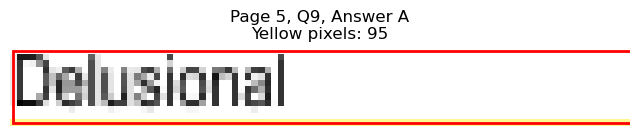

Page 5, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=103.9, y1=632.4
Page 5, Q9, B: Yellow pixels: 804
Page 5, Q9, B: Total non-white pixels: 1032
Page 5, Q9, B: Yellow percentage: 77.9%


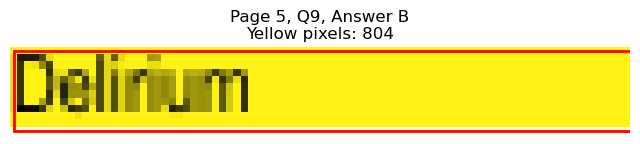

Page 5, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=355.6, y1=619.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 140
Page 5, Q9, C: Yellow percentage: 0.0%


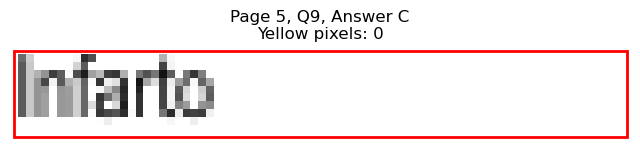

Page 5, Q9 - D: Detected box: x0=327.5, y0=103.8, x1=356.0, y1=114.8
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 145
Page 5, Q9, D: Yellow percentage: 0.0%


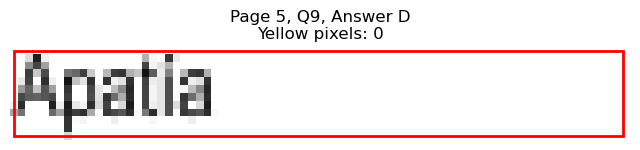


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=709.6, x1=142.0, y1=720.7
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 394
Page 5, Q10, A: Yellow percentage: 0.0%


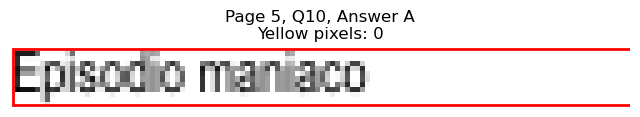

Page 5, Q10 - B: Detected box: x0=68.3, y0=722.2, x1=172.6, y1=733.3
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 524
Page 5, Q10, B: Yellow percentage: 0.0%


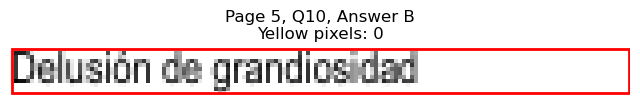

Page 5, Q10 - C: Detected box: x0=327.5, y0=709.6, x1=406.2, y1=720.7
Page 5, Q10, C: Yellow pixels: 130
Page 5, Q10, C: Total non-white pixels: 549
Page 5, Q10, C: Yellow percentage: 23.7%


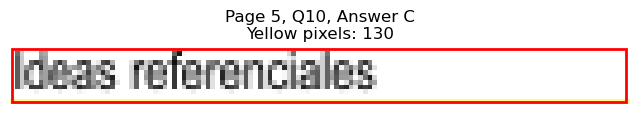

Page 5, Q10 - D: Detected box: x0=327.5, y0=722.2, x1=423.2, y1=733.3
Page 5, Q10, D: Yellow pixels: 1241
Page 5, Q10, D: Total non-white pixels: 1764
Page 5, Q10, D: Yellow percentage: 70.4%


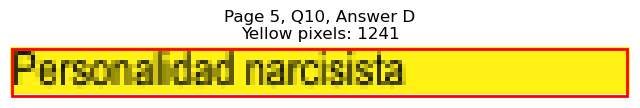


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=96.4, y1=102.2
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 142
Page 6, Q1, A: Yellow percentage: 0.0%


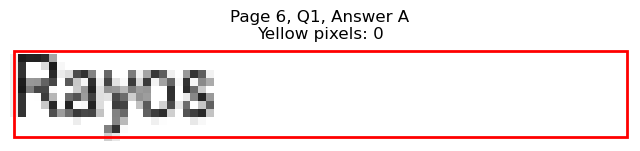

Page 6, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=97.9, y1=114.8
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 136
Page 6, Q1, B: Yellow percentage: 0.0%


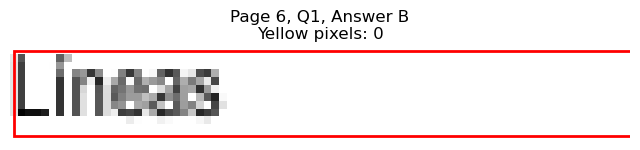

Page 6, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=362.6, y1=102.2
Page 6, Q1, C: Yellow pixels: 86
Page 6, Q1, C: Total non-white pixels: 335
Page 6, Q1, C: Yellow percentage: 25.7%


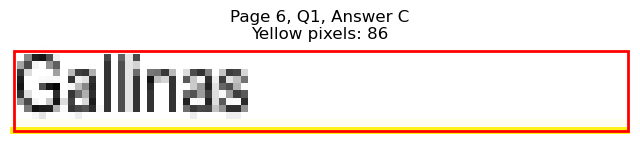

Page 6, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=354.1, y1=114.8
Page 6, Q1, D: Yellow pixels: 842
Page 6, Q1, D: Total non-white pixels: 936
Page 6, Q1, D: Yellow percentage: 90.0%


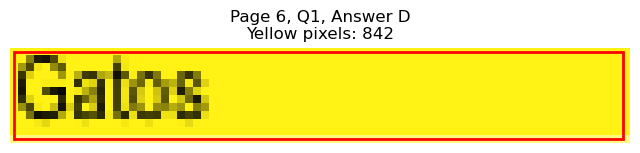


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=201.6, y1=165.3
Page 6, Q2, A: Yellow pixels: 1546
Page 6, Q2, A: Total non-white pixels: 2208
Page 6, Q2, A: Yellow percentage: 70.0%


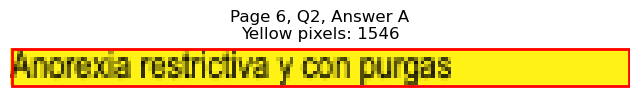

Page 6, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=147.5, y1=177.9
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 392
Page 6, Q2, B: Yellow percentage: 0.0%


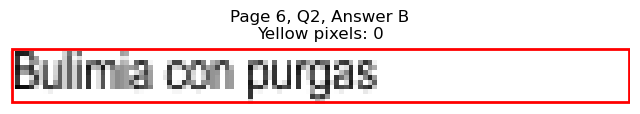

Page 6, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=422.8, y1=165.3
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 484
Page 6, Q2, C: Yellow percentage: 0.0%


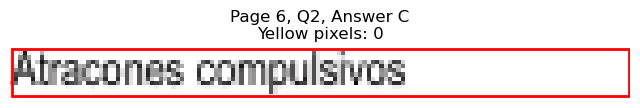

Page 6, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=438.8, y1=177.9
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 543
Page 6, Q2, D: Yellow percentage: 0.0%


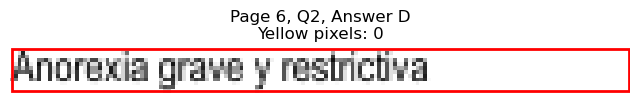


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=168.6, y1=215.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 534
Page 6, Q3, A: Yellow percentage: 0.0%


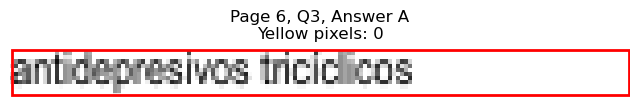

Page 6, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=188.2, y1=228.4
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 661
Page 6, Q3, B: Yellow percentage: 0.0%


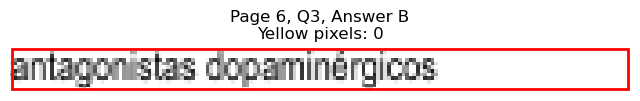

Page 6, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=417.2, y1=215.7
Page 6, Q3, C: Yellow pixels: 1354
Page 6, Q3, C: Total non-white pixels: 1692
Page 6, Q3, C: Yellow percentage: 80.0%


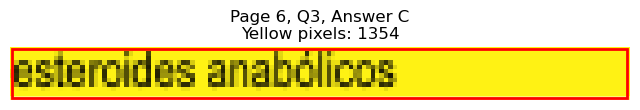

Page 6, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=420.2, y1=228.4
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 505
Page 6, Q3, D: Yellow percentage: 0.0%


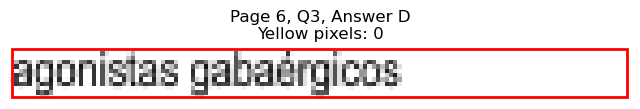


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=102.8, y1=266.2
Page 6, Q4, A: Yellow pixels: 85
Page 6, Q4, A: Total non-white pixels: 263
Page 6, Q4, A: Yellow percentage: 32.3%


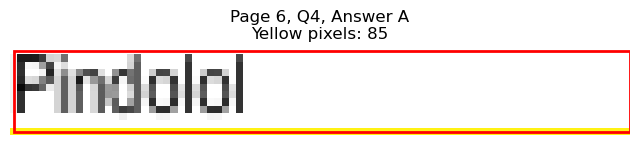

Page 6, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=116.9, y1=278.8
Page 6, Q4, B: Yellow pixels: 1025
Page 6, Q4, B: Total non-white pixels: 1188
Page 6, Q4, B: Yellow percentage: 86.3%


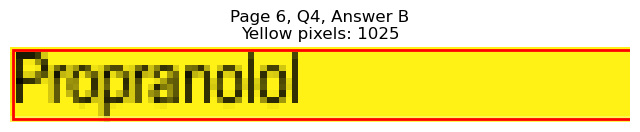

Page 6, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=380.6, y1=266.2
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 273
Page 6, Q4, C: Yellow percentage: 0.0%


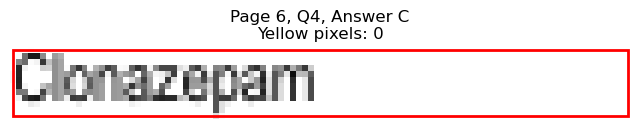

Page 6, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=374.6, y1=278.8
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 218
Page 6, Q4, D: Yellow percentage: 0.0%


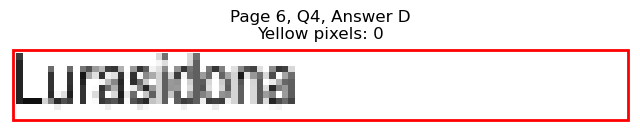


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=305.7, x1=115.0, y1=316.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 253
Page 6, Q5, A: Yellow percentage: 0.0%


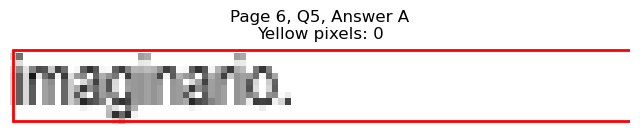

Page 6, Q5 - B: Detected box: x0=68.3, y0=318.3, x1=95.4, y1=329.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 127
Page 6, Q5, B: Yellow percentage: 0.0%


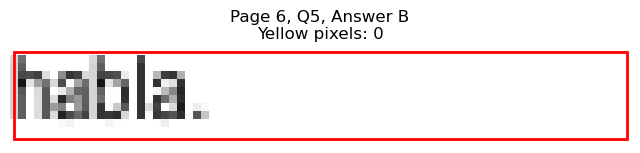

Page 6, Q5 - C: Detected box: x0=327.5, y0=305.7, x1=384.1, y1=316.8
Page 6, Q5, C: Yellow pixels: 1092
Page 6, Q5, C: Total non-white pixels: 1296
Page 6, Q5, C: Yellow percentage: 84.3%


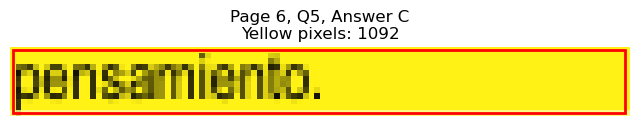

Page 6, Q5 - D: Detected box: x0=327.5, y0=318.3, x1=366.6, y1=329.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 180
Page 6, Q5, D: Yellow percentage: 0.0%


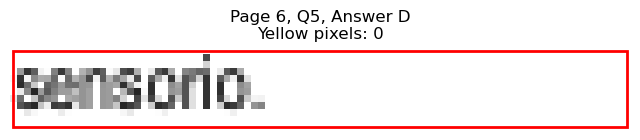


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=356.2, x1=162.6, y1=367.3
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 474
Page 6, Q6, A: Yellow percentage: 0.0%


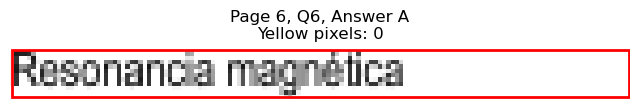

Page 6, Q6 - B: Detected box: x0=68.3, y0=368.8, x1=86.9, y1=379.9
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 87
Page 6, Q6, B: Yellow percentage: 0.0%


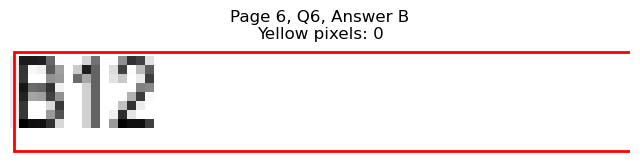

Page 6, Q6 - C: Detected box: x0=327.5, y0=356.2, x1=414.7, y1=367.3
Page 6, Q6, C: Yellow pixels: 138
Page 6, Q6, C: Total non-white pixels: 602
Page 6, Q6, C: Yellow percentage: 22.9%


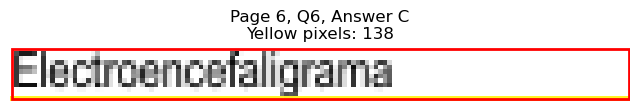

Page 6, Q6 - D: Detected box: x0=327.5, y0=368.8, x1=348.0, y1=379.9
Page 6, Q6, D: Yellow pixels: 780
Page 6, Q6, D: Total non-white pixels: 852
Page 6, Q6, D: Yellow percentage: 91.5%


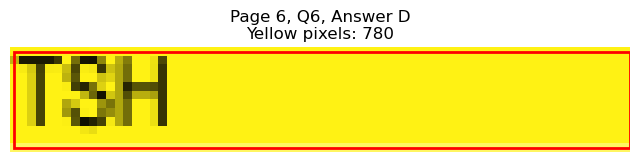


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=432.0, x1=141.0, y1=443.0
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 391
Page 6, Q7, A: Yellow percentage: 0.0%


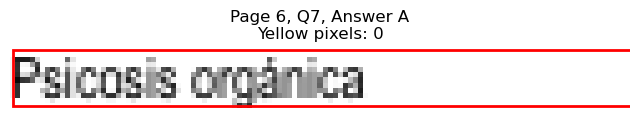

Page 6, Q7 - B: Detected box: x0=68.3, y0=444.6, x1=103.4, y1=455.6
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 171
Page 6, Q7, B: Yellow percentage: 0.0%


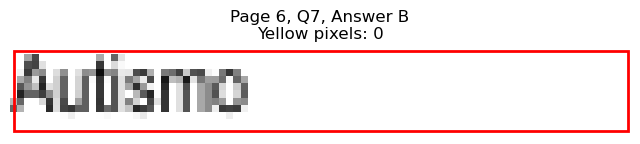

Page 6, Q7 - C: Detected box: x0=327.5, y0=432.0, x1=411.2, y1=443.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 570
Page 6, Q7, C: Yellow percentage: 0.0%


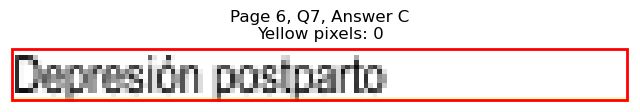

Page 6, Q7 - D: Detected box: x0=327.5, y0=444.6, x1=403.2, y1=455.6
Page 6, Q7, D: Yellow pixels: 1092
Page 6, Q7, D: Total non-white pixels: 1524
Page 6, Q7, D: Yellow percentage: 71.7%


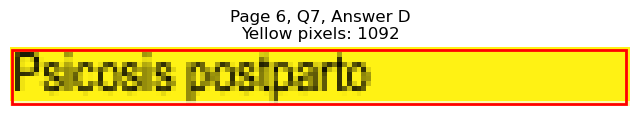


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=482.5, x1=124.0, y1=493.5
Page 6, Q8, A: Yellow pixels: 954
Page 6, Q8, A: Total non-white pixels: 1272
Page 6, Q8, A: Yellow percentage: 75.0%


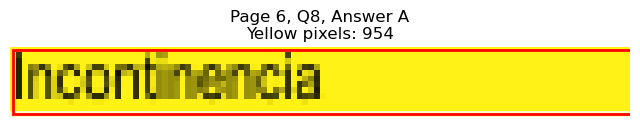

Page 6, Q8 - B: Detected box: x0=68.3, y0=495.1, x1=113.9, y1=506.1
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 230
Page 6, Q8, B: Yellow percentage: 0.0%


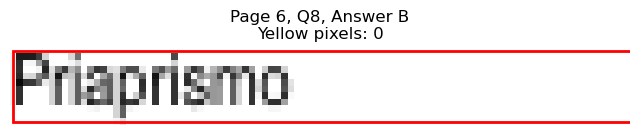

Page 6, Q8 - C: Detected box: x0=327.5, y0=482.5, x1=368.2, y1=493.5
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 228
Page 6, Q8, C: Yellow percentage: 0.0%


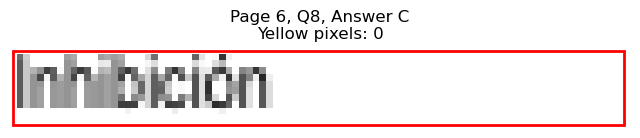

Page 6, Q8 - D: Detected box: x0=327.5, y0=495.1, x1=357.6, y1=506.1
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 141
Page 6, Q8, D: Yellow percentage: 0.0%


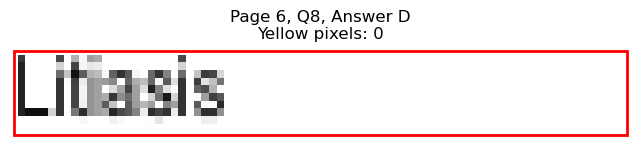


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=545.5, x1=139.6, y1=556.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 348
Page 6, Q9, A: Yellow percentage: 0.0%


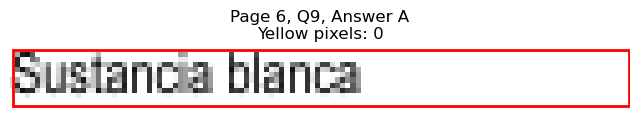

Page 6, Q9 - B: Detected box: x0=68.3, y0=558.2, x1=138.5, y1=569.2
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 340
Page 6, Q9, B: Yellow percentage: 0.0%


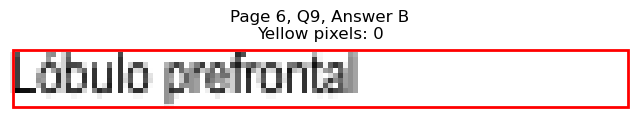

Page 6, Q9 - C: Detected box: x0=327.5, y0=545.5, x1=431.3, y1=556.5
Page 6, Q9, C: Yellow pixels: 1303
Page 6, Q9, C: Total non-white pixels: 1860
Page 6, Q9, C: Yellow percentage: 70.1%


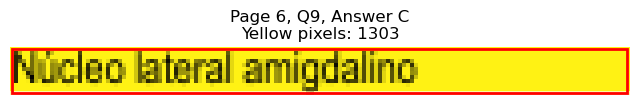

Page 6, Q9 - D: Detected box: x0=327.5, y0=558.2, x1=412.2, y1=569.2
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 426
Page 6, Q9, D: Yellow percentage: 0.0%


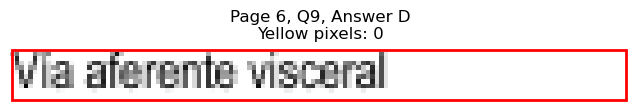


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=596.0, x1=112.0, y1=607.0
Page 6, Q10, A: Yellow pixels: 965
Page 6, Q10, A: Total non-white pixels: 1130
Page 6, Q10, A: Yellow percentage: 85.4%


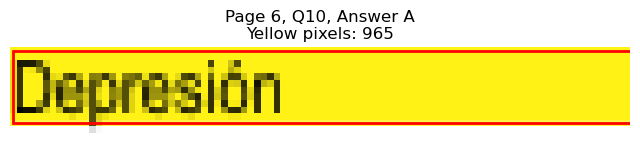

Page 6, Q10 - B: Detected box: x0=68.3, y0=608.6, x1=98.4, y1=619.6
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 158
Page 6, Q10, B: Yellow percentage: 0.0%


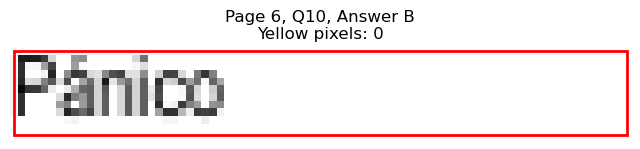

Page 6, Q10 - C: Detected box: x0=327.5, y0=596.0, x1=355.6, y1=607.0
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 153
Page 6, Q10, C: Yellow percentage: 0.0%


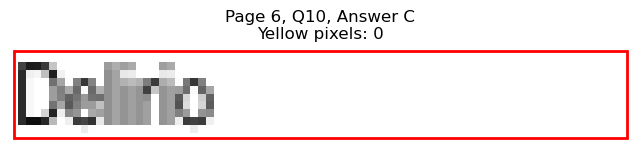

Page 6, Q10 - D: Detected box: x0=327.5, y0=608.6, x1=383.2, y1=619.6
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 300
Page 6, Q10, D: Yellow percentage: 0.0%


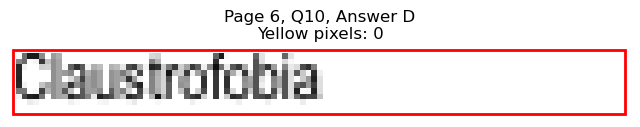


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=646.5, x1=113.4, y1=657.6
Page 6, Q11, A: Yellow pixels: 96
Page 6, Q11, A: Total non-white pixels: 330
Page 6, Q11, A: Yellow percentage: 29.1%


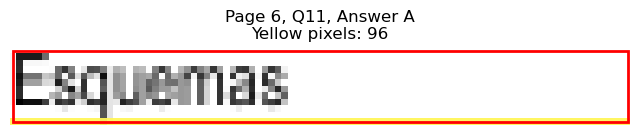

Page 6, Q11 - B: Detected box: x0=68.3, y0=659.1, x1=156.6, y1=670.2
Page 6, Q11, B: Yellow pixels: 1193
Page 6, Q11, B: Total non-white pixels: 1529
Page 6, Q11, B: Yellow percentage: 78.0%


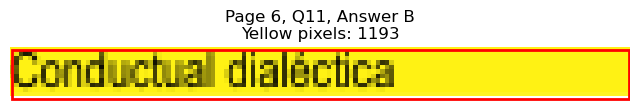

Page 6, Q11 - C: Detected box: x0=327.5, y0=646.5, x1=402.2, y1=657.6
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 366
Page 6, Q11, C: Yellow percentage: 0.0%


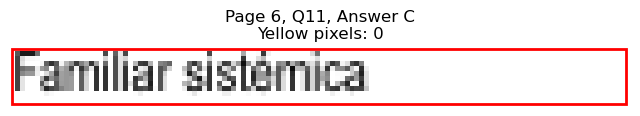

Page 6, Q11 - D: Detected box: x0=327.5, y0=659.1, x1=376.7, y1=670.2
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 242
Page 6, Q11, D: Yellow percentage: 0.0%


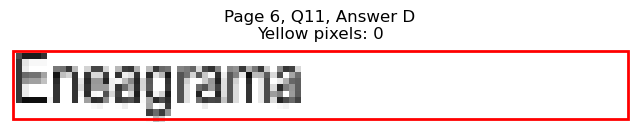


Page 6, Q11 - Selected Answer: B (based on yellow pixel count)




Page 6, Q12 - A: Detected box: x0=68.3, y0=709.6, x1=110.9, y1=720.7
Page 6, Q12, A: Yellow pixels: 0
Page 6, Q12, A: Total non-white pixels: 217
Page 6, Q12, A: Yellow percentage: 0.0%


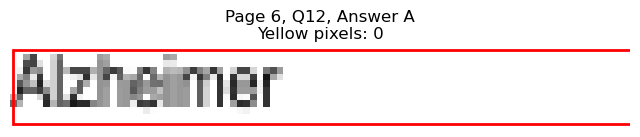

Page 6, Q12 - B: Detected box: x0=68.3, y0=722.2, x1=105.8, y1=733.3
Page 6, Q12, B: Yellow pixels: 0
Page 6, Q12, B: Total non-white pixels: 167
Page 6, Q12, B: Yellow percentage: 0.0%


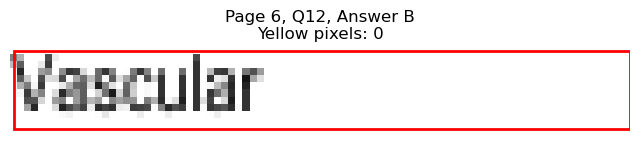

Page 6, Q12 - C: Detected box: x0=327.5, y0=709.6, x1=391.2, y1=720.7
Page 6, Q12, C: Yellow pixels: 1124
Page 6, Q12, C: Total non-white pixels: 1380
Page 6, Q12, C: Yellow percentage: 81.4%


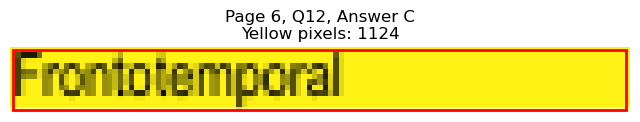

Page 6, Q12 - D: Detected box: x0=327.5, y0=722.2, x1=400.2, y1=733.3
Page 6, Q12, D: Yellow pixels: 0
Page 6, Q12, D: Total non-white pixels: 350
Page 6, Q12, D: Yellow percentage: 0.0%


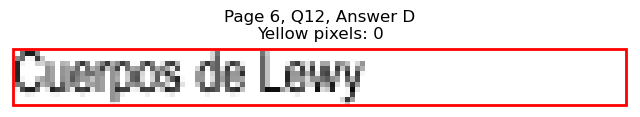


Page 6, Q12 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=100.3, y1=114.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 177
Page 7, Q1, A: Yellow percentage: 0.0%


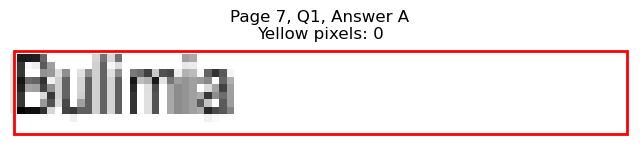

Page 7, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=106.4, y1=127.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 192
Page 7, Q1, B: Yellow percentage: 0.0%


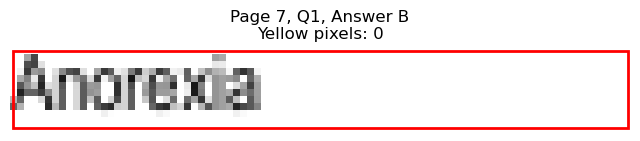

Page 7, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=373.6, y1=114.8
Page 7, Q1, C: Yellow pixels: 97
Page 7, Q1, C: Total non-white pixels: 349
Page 7, Q1, C: Yellow percentage: 27.8%


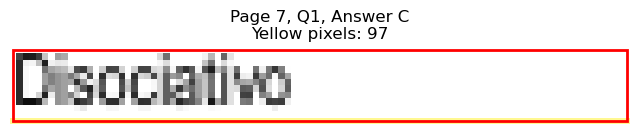

Page 7, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=370.6, y1=127.4
Page 7, Q1, D: Yellow pixels: 869
Page 7, Q1, D: Total non-white pixels: 1128
Page 7, Q1, D: Yellow percentage: 77.0%


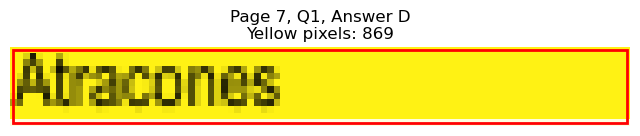


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=156.0, y1=190.5
Page 7, Q2, A: Yellow pixels: 1198
Page 7, Q2, A: Total non-white pixels: 1656
Page 7, Q2, A: Yellow percentage: 72.3%


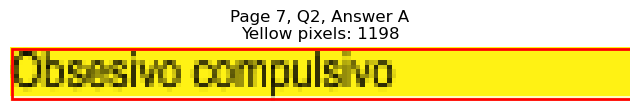

Page 7, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=196.2, y1=203.1
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 675
Page 7, Q2, B: Yellow percentage: 0.0%


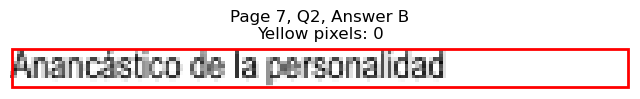

Page 7, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=384.7, y1=190.5
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 317
Page 7, Q2, C: Yellow percentage: 0.0%


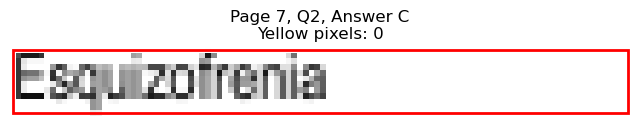

Page 7, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=358.1, y1=203.1
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 147
Page 7, Q2, D: Yellow percentage: 0.0%


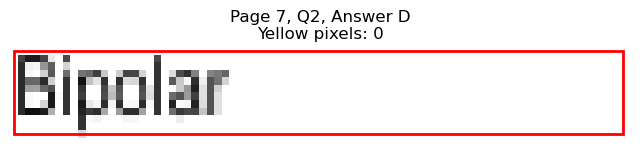


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=151.1, y1=266.2
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 413
Page 7, Q3, A: Yellow percentage: 0.0%


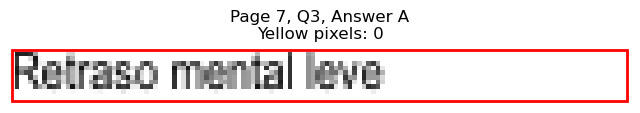

Page 7, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=125.5, y1=278.8
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 319
Page 7, Q3, B: Yellow percentage: 0.0%


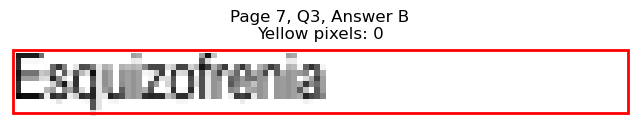

Page 7, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=366.6, y1=266.2
Page 7, Q3, C: Yellow pixels: 819
Page 7, Q3, C: Total non-white pixels: 995
Page 7, Q3, C: Yellow percentage: 82.3%


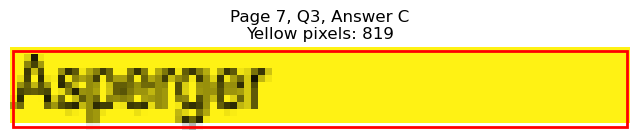

Page 7, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=434.3, y1=278.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 539
Page 7, Q3, D: Yellow percentage: 0.0%


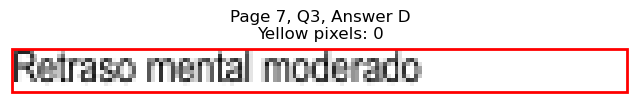


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=119.4, y1=316.8
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 280
Page 7, Q4, A: Yellow percentage: 0.0%


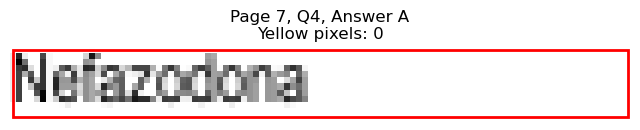

Page 7, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=113.4, y1=329.4
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 245
Page 7, Q4, B: Yellow percentage: 0.0%


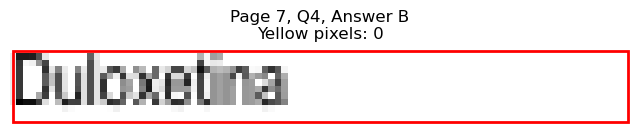

Page 7, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=381.1, y1=316.8
Page 7, Q4, C: Yellow pixels: 1055
Page 7, Q4, C: Total non-white pixels: 1260
Page 7, Q4, C: Yellow percentage: 83.7%


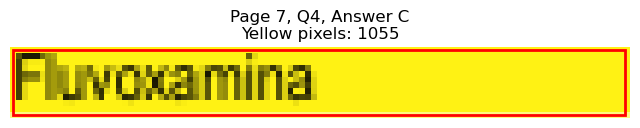

Page 7, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=374.6, y1=329.4
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 230
Page 7, Q4, D: Yellow percentage: 0.0%


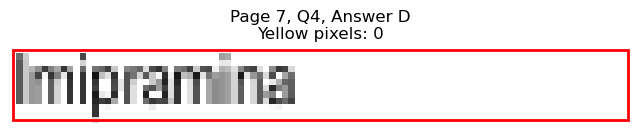


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=133.4, y1=417.7
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 310
Page 7, Q5, A: Yellow percentage: 0.0%


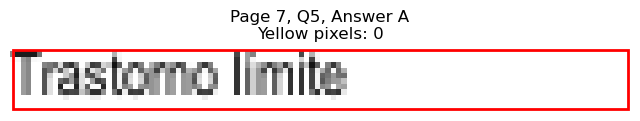

Page 7, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=131.5, y1=430.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 348
Page 7, Q5, B: Yellow percentage: 0.0%


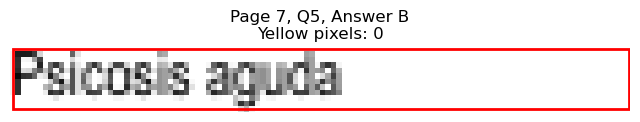

Page 7, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=401.2, y1=417.7
Page 7, Q5, C: Yellow pixels: 1236
Page 7, Q5, C: Total non-white pixels: 1500
Page 7, Q5, C: Yellow percentage: 82.4%


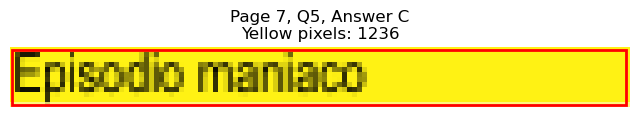

Page 7, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=376.1, y1=430.4
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 265
Page 7, Q5, D: Yellow percentage: 0.0%


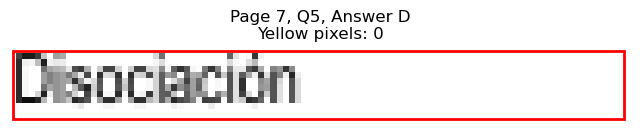


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=119.4, y1=493.5
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 270
Page 7, Q6, A: Yellow percentage: 0.0%


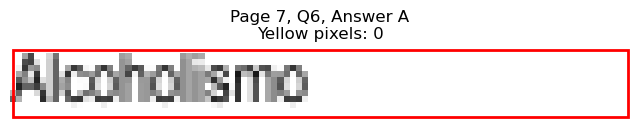

Page 7, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=111.4, y1=506.1
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 214
Page 7, Q6, B: Yellow percentage: 0.0%


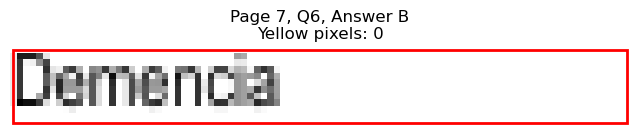

Page 7, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=398.8, y1=493.5
Page 7, Q6, C: Yellow pixels: 1038
Page 7, Q6, C: Total non-white pixels: 1464
Page 7, Q6, C: Yellow percentage: 70.9%


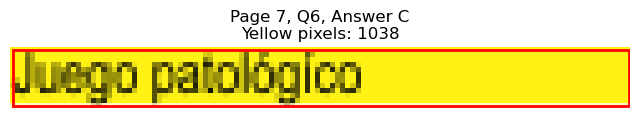

Page 7, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=372.1, y1=506.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 235
Page 7, Q6, D: Yellow percentage: 0.0%


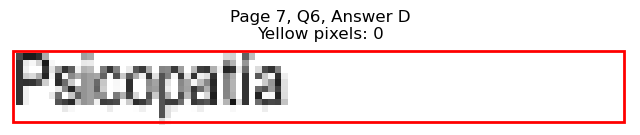


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=118.9, y1=556.5
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 242
Page 7, Q7, A: Yellow percentage: 0.0%


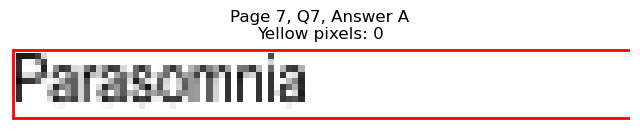

Page 7, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=123.5, y1=569.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 274
Page 7, Q7, B: Yellow percentage: 0.0%


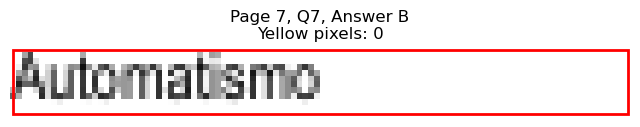

Page 7, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=366.6, y1=556.5
Page 7, Q7, C: Yellow pixels: 840
Page 7, Q7, C: Total non-white pixels: 1080
Page 7, Q7, C: Yellow percentage: 77.8%


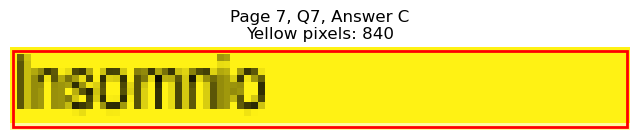

Page 7, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=367.1, y1=569.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 217
Page 7, Q7, D: Yellow percentage: 0.0%


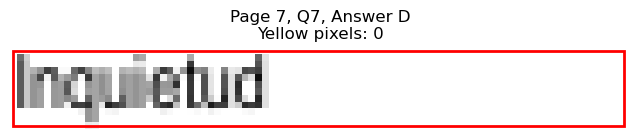


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=103.9, y1=619.6
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 192
Page 7, Q8, A: Yellow percentage: 0.0%


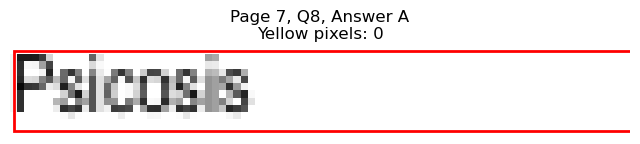

Page 7, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=98.4, y1=632.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 158
Page 7, Q8, B: Yellow percentage: 0.0%


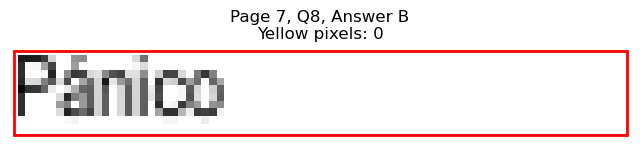

Page 7, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=371.2, y1=619.6
Page 7, Q8, C: Yellow pixels: 961
Page 7, Q8, C: Total non-white pixels: 1140
Page 7, Q8, C: Yellow percentage: 84.3%


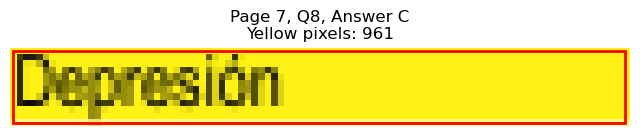

Page 7, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=375.1, y1=632.4
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 249
Page 7, Q8, D: Yellow percentage: 0.0%


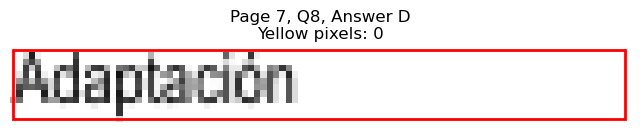


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=659.1, x1=108.4, y1=670.2
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 211
Page 7, Q9, A: Yellow percentage: 0.0%


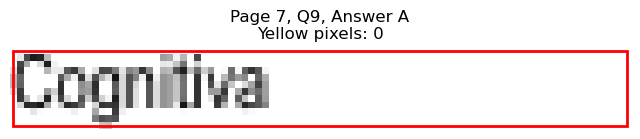

Page 7, Q9 - B: Detected box: x0=68.3, y0=671.7, x1=113.9, y1=682.8
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 219
Page 7, Q9, B: Yellow percentage: 0.0%


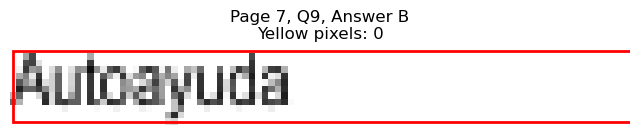

Page 7, Q9 - C: Detected box: x0=327.5, y0=659.1, x1=388.2, y1=670.2
Page 7, Q9, C: Yellow pixels: 1007
Page 7, Q9, C: Total non-white pixels: 1232
Page 7, Q9, C: Yellow percentage: 81.7%


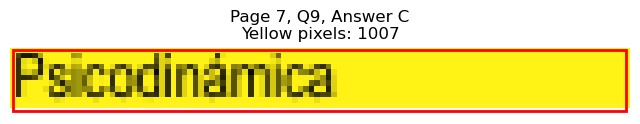

Page 7, Q9 - D: Detected box: x0=327.5, y0=671.7, x1=375.6, y1=682.8
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 255
Page 7, Q9, D: Yellow percentage: 0.0%


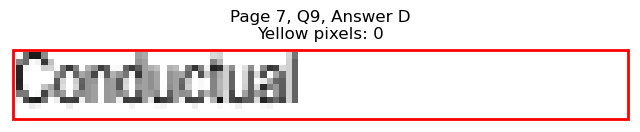


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=734.8, x1=111.4, y1=745.9
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 239
Page 7, Q10, A: Yellow percentage: 0.0%


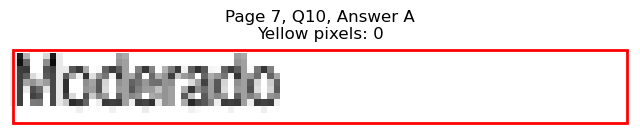

Page 7, Q10 - B: Detected box: x0=68.3, y0=747.4, x1=95.4, y1=758.5
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 131
Page 7, Q10, B: Yellow percentage: 0.0%


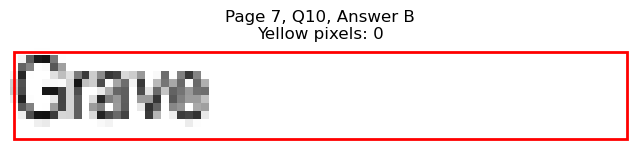

Page 7, Q10 - C: Detected box: x0=327.5, y0=734.8, x1=370.6, y1=745.9
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 313
Page 7, Q10, C: Yellow percentage: 0.0%


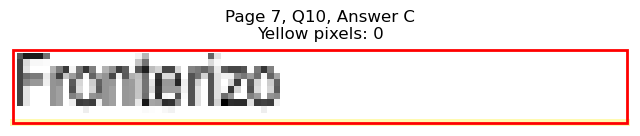

Page 7, Q10 - D: Detected box: x0=327.5, y0=747.4, x1=349.6, y1=758.5
Page 7, Q10, D: Yellow pixels: 732
Page 7, Q10, D: Total non-white pixels: 876
Page 7, Q10, D: Yellow percentage: 83.6%


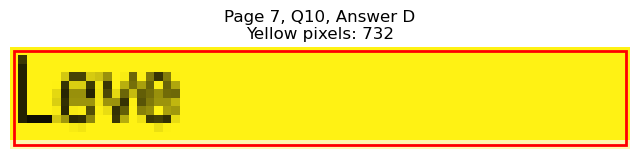


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=96.8, y1=114.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 132
Page 8, Q1, A: Yellow percentage: 0.0%


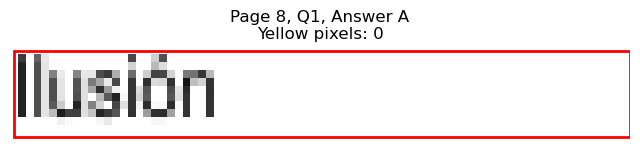

Page 8, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=118.0, y1=127.4
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 261
Page 8, Q1, B: Yellow percentage: 0.0%


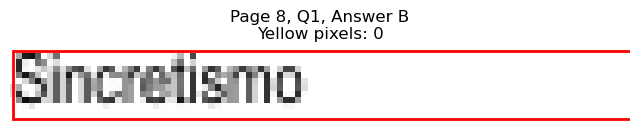

Page 8, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=369.1, y1=114.8
Page 8, Q1, C: Yellow pixels: 952
Page 8, Q1, C: Total non-white pixels: 1116
Page 8, Q1, C: Yellow percentage: 85.3%


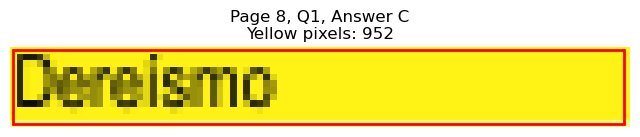

Page 8, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=376.7, y1=127.4
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 254
Page 8, Q1, D: Yellow percentage: 0.0%


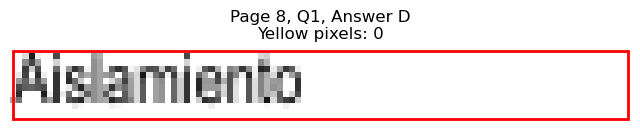


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=130.4, y1=177.9
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 326
Page 8, Q2, A: Yellow percentage: 0.0%


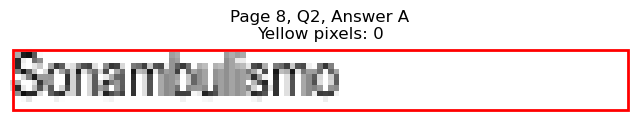

Page 8, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=104.9, y1=190.5
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 201
Page 8, Q2, B: Yellow percentage: 0.0%


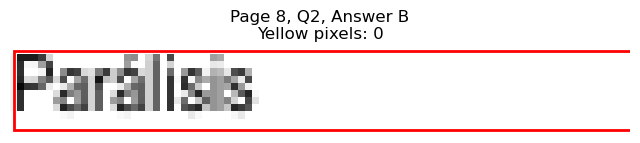

Page 8, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=372.6, y1=177.9
Page 8, Q2, C: Yellow pixels: 971
Page 8, Q2, C: Total non-white pixels: 1152
Page 8, Q2, C: Yellow percentage: 84.3%


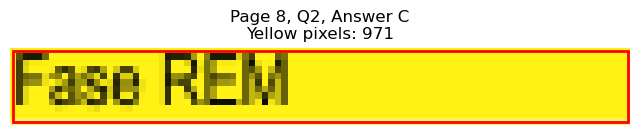

Page 8, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=375.6, y1=190.5
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 283
Page 8, Q2, D: Yellow percentage: 0.0%


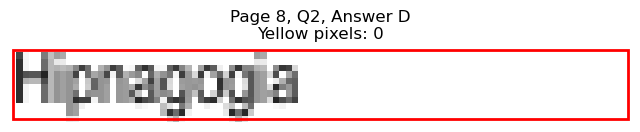


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=112.0, y1=266.2
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 223
Page 8, Q3, A: Yellow percentage: 0.0%


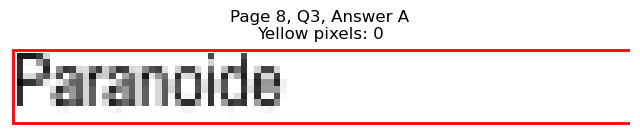

Page 8, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=131.5, y1=278.8
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 317
Page 8, Q3, B: Yellow percentage: 0.0%


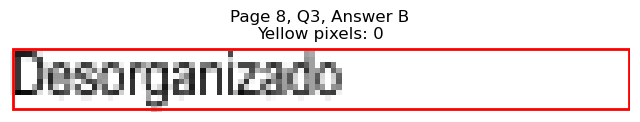

Page 8, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=415.2, y1=266.2
Page 8, Q3, C: Yellow pixels: 1214
Page 8, Q3, C: Total non-white pixels: 1531
Page 8, Q3, C: Yellow percentage: 79.3%


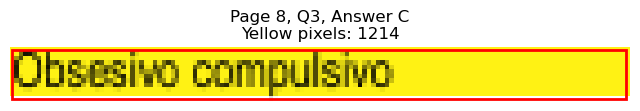

Page 8, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=393.7, y1=278.8
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 339
Page 8, Q3, D: Yellow percentage: 0.0%


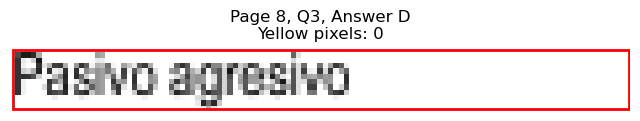


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=119.9, y1=329.4
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 259
Page 8, Q4, A: Yellow percentage: 0.0%


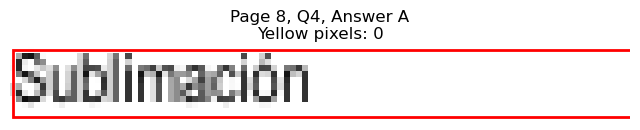

Page 8, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=135.5, y1=342.0
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 339
Page 8, Q4, B: Yellow percentage: 0.0%


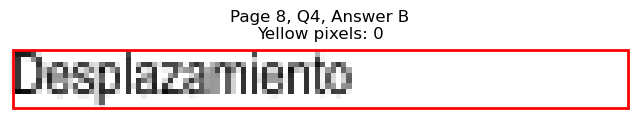

Page 8, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=370.1, y1=329.4
Page 8, Q4, C: Yellow pixels: 94
Page 8, Q4, C: Total non-white pixels: 289
Page 8, Q4, C: Yellow percentage: 32.5%


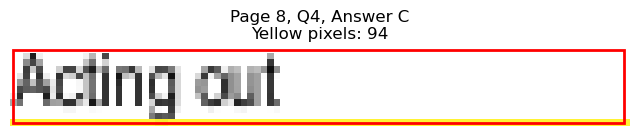

Page 8, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=406.7, y1=342.0
Page 8, Q4, D: Yellow pixels: 1275
Page 8, Q4, D: Total non-white pixels: 1560
Page 8, Q4, D: Yellow percentage: 81.7%


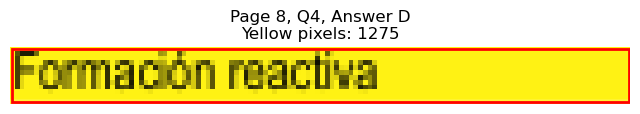


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=86.9, y1=392.5
Page 8, Q5, A: Yellow pixels: 69
Page 8, Q5, A: Total non-white pixels: 174
Page 8, Q5, A: Yellow percentage: 39.7%


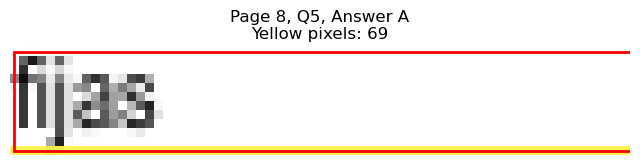

Page 8, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=91.9, y1=405.1
Page 8, Q5, B: Yellow pixels: 715
Page 8, Q5, B: Total non-white pixels: 814
Page 8, Q5, B: Yellow percentage: 87.8%


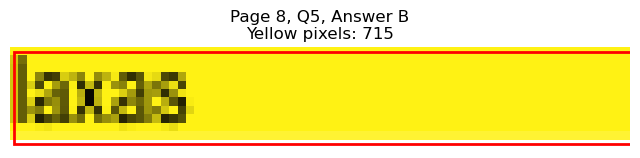

Page 8, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=366.1, y1=392.5
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 201
Page 8, Q5, C: Yellow percentage: 0.0%


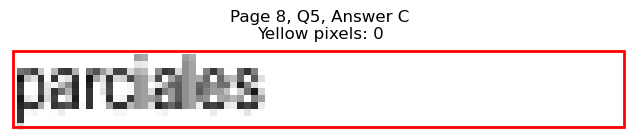

Page 8, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=351.6, y1=405.1
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 105
Page 8, Q5, D: Yellow percentage: 0.0%


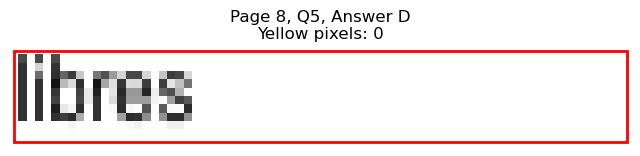


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=105.8, y1=455.6
Page 8, Q6, A: Yellow pixels: 832
Page 8, Q6, A: Total non-white pixels: 1056
Page 8, Q6, A: Yellow percentage: 78.8%


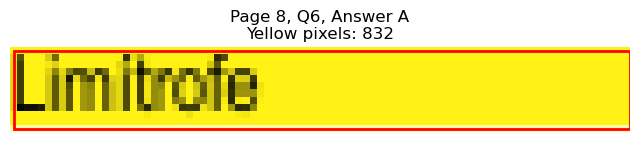

Page 8, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=121.9, y1=468.2
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 303
Page 8, Q6, B: Yellow percentage: 0.0%


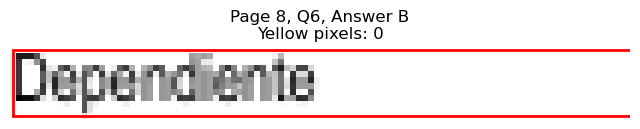

Page 8, Q6 - C: Detected box: x0=327.5, y0=444.6, x1=368.6, y1=455.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 211
Page 8, Q6, C: Yellow percentage: 0.0%


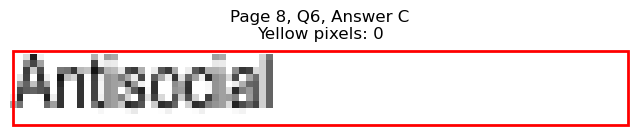

Page 8, Q6 - D: Detected box: x0=327.5, y0=457.2, x1=379.2, y1=468.2
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 253
Page 8, Q6, D: Yellow percentage: 0.0%


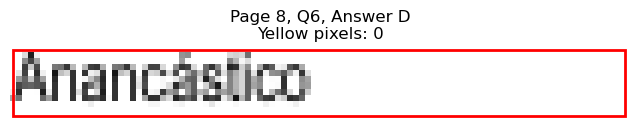


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=143.5, y1=518.7
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 364
Page 8, Q7, A: Yellow percentage: 0.0%


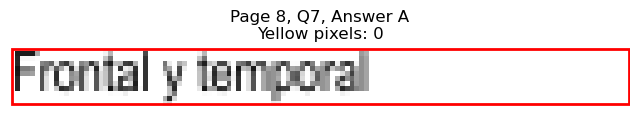

Page 8, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=142.0, y1=531.3
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 358
Page 8, Q7, B: Yellow percentage: 0.0%


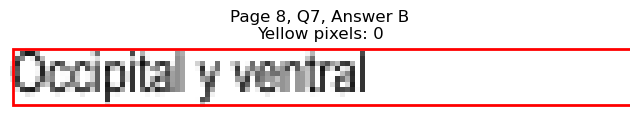

Page 8, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=408.7, y1=518.7
Page 8, Q7, C: Yellow pixels: 132
Page 8, Q7, C: Total non-white pixels: 541
Page 8, Q7, C: Yellow percentage: 24.4%


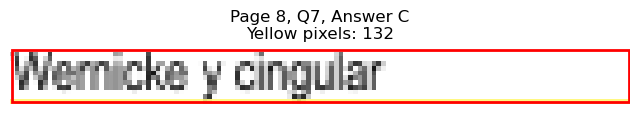

Page 8, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=398.8, y1=531.3
Page 8, Q7, D: Yellow pixels: 1069
Page 8, Q7, D: Total non-white pixels: 1464
Page 8, Q7, D: Yellow percentage: 73.0%


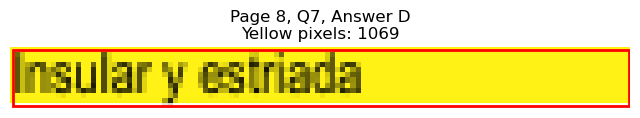


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=570.8, x1=106.9, y1=581.8
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 206
Page 8, Q8, A: Yellow percentage: 0.0%


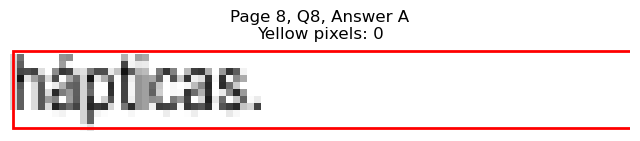

Page 8, Q8 - B: Detected box: x0=68.3, y0=583.4, x1=106.0, y1=594.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 174
Page 8, Q8, B: Yellow percentage: 0.0%


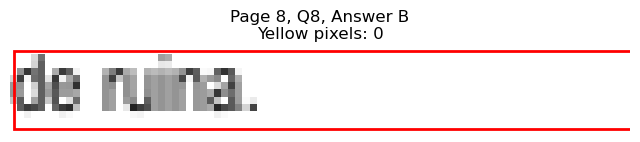

Page 8, Q8 - C: Detected box: x0=327.5, y0=570.8, x1=368.2, y1=581.8
Page 8, Q8, C: Yellow pixels: 1
Page 8, Q8, C: Total non-white pixels: 281
Page 8, Q8, C: Yellow percentage: 0.4%


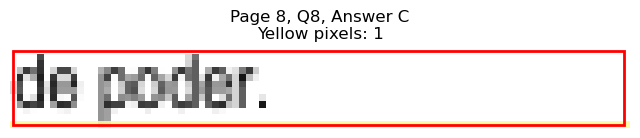

Page 8, Q8 - D: Detected box: x0=327.5, y0=583.4, x1=384.1, y1=594.4
Page 8, Q8, D: Yellow pixels: 968
Page 8, Q8, D: Total non-white pixels: 1296
Page 8, Q8, D: Yellow percentage: 74.7%


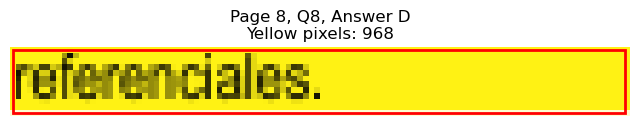


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=621.3, x1=88.3, y1=632.4
Page 8, Q9, A: Yellow pixels: 725
Page 8, Q9, A: Total non-white pixels: 852
Page 8, Q9, A: Yellow percentage: 85.1%


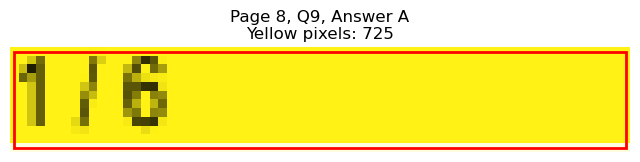

Page 8, Q9 - B: Detected box: x0=68.3, y0=633.9, x1=93.4, y1=645.0
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 97
Page 8, Q9, B: Yellow percentage: 0.0%


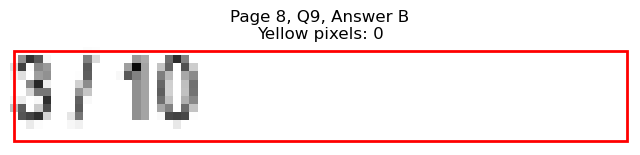

Page 8, Q9 - C: Detected box: x0=327.5, y0=621.3, x1=352.6, y1=632.4
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 97
Page 8, Q9, C: Yellow percentage: 0.0%


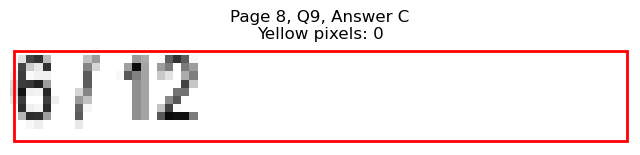

Page 8, Q9 - D: Detected box: x0=327.5, y0=633.9, x1=347.5, y1=645.0
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 77
Page 8, Q9, D: Yellow percentage: 0.0%


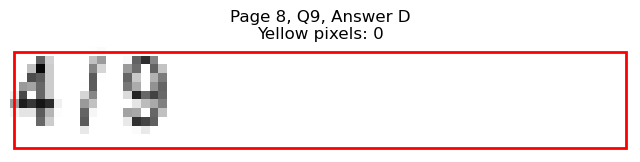


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=722.2, x1=94.3, y1=733.3
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 142
Page 8, Q10, A: Yellow percentage: 0.0%


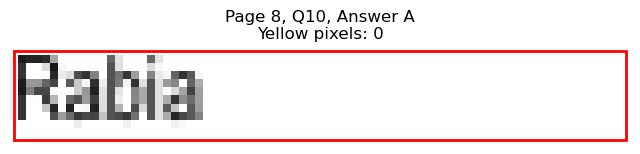

Page 8, Q10 - B: Detected box: x0=68.3, y0=734.8, x1=110.4, y1=745.9
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 221
Page 8, Q10, B: Yellow percentage: 0.0%


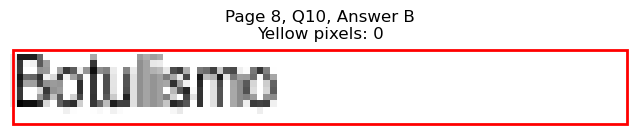

Page 8, Q10 - C: Detected box: x0=327.5, y0=722.2, x1=408.7, y1=733.3
Page 8, Q10, C: Yellow pixels: 132
Page 8, Q10, C: Total non-white pixels: 514
Page 8, Q10, C: Yellow percentage: 25.7%


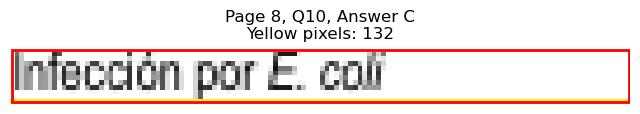

Page 8, Q10 - D: Detected box: x0=327.5, y0=734.8, x1=430.8, y1=745.9
Page 8, Q10, D: Yellow pixels: 1461
Page 8, Q10, D: Total non-white pixels: 1848
Page 8, Q10, D: Yellow percentage: 79.1%


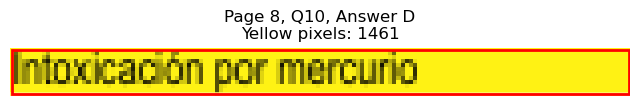


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=103.9, y1=102.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 185
Page 9, Q1, A: Yellow percentage: 0.0%


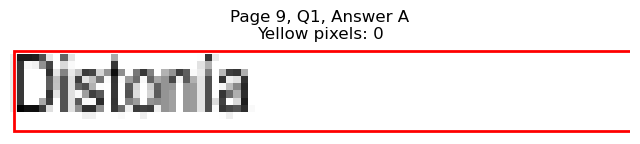

Page 9, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=122.9, y1=114.8
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 272
Page 9, Q1, B: Yellow percentage: 0.0%


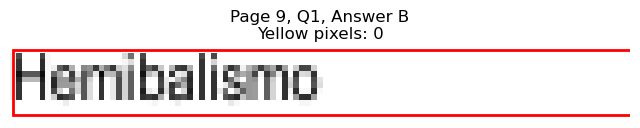

Page 9, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=376.2, y1=102.2
Page 9, Q1, C: Yellow pixels: 936
Page 9, Q1, C: Total non-white pixels: 1100
Page 9, Q1, C: Yellow percentage: 85.1%


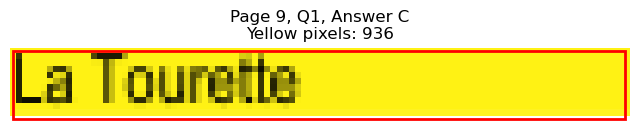

Page 9, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=354.6, y1=114.8
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 131
Page 9, Q1, D: Yellow percentage: 0.0%


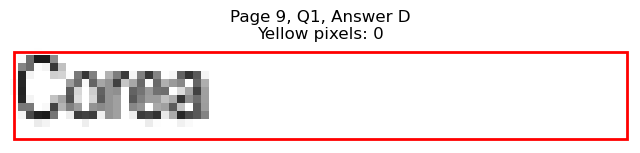


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=88.3, y1=165.3
Page 9, Q2, A: Yellow pixels: 71
Page 9, Q2, A: Total non-white pixels: 173
Page 9, Q2, A: Yellow percentage: 41.0%


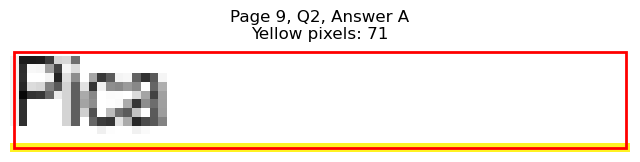

Page 9, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=113.4, y1=177.9
Page 9, Q2, B: Yellow pixels: 984
Page 9, Q2, B: Total non-white pixels: 1152
Page 9, Q2, B: Yellow percentage: 85.4%


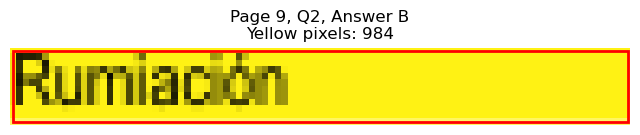

Page 9, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=428.3, y1=165.3
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 537
Page 9, Q2, C: Yellow percentage: 0.0%


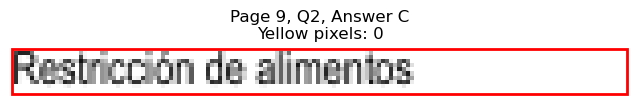

Page 9, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=370.6, y1=177.9
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 219
Page 9, Q2, D: Yellow percentage: 0.0%


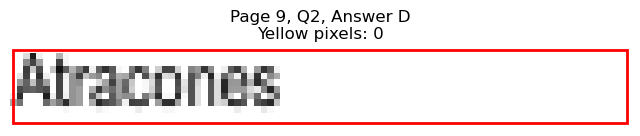


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=91.3, y1=266.2
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 112
Page 9, Q3, A: Yellow percentage: 0.0%


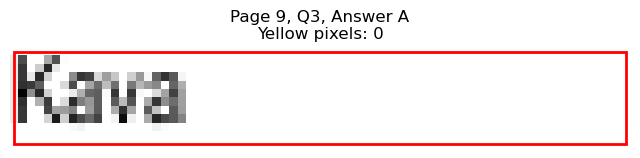

Page 9, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=103.9, y1=278.8
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 198
Page 9, Q3, B: Yellow percentage: 0.0%


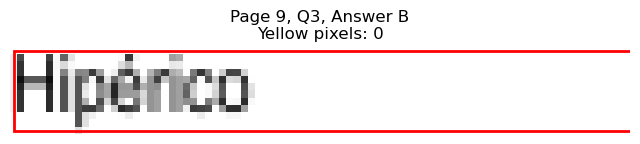

Page 9, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=357.1, y1=266.2
Page 9, Q3, C: Yellow pixels: 81
Page 9, Q3, C: Total non-white pixels: 196
Page 9, Q3, C: Yellow percentage: 41.3%


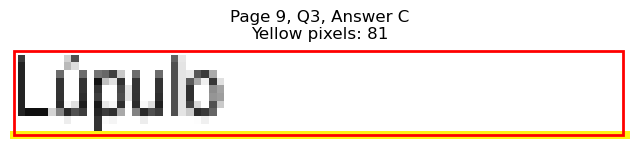

Page 9, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=363.6, y1=278.8
Page 9, Q3, D: Yellow pixels: 899
Page 9, Q3, D: Total non-white pixels: 1044
Page 9, Q3, D: Yellow percentage: 86.1%


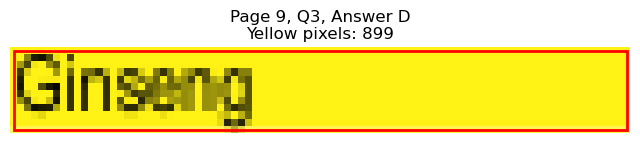


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=170.6, y1=342.0
Page 9, Q4, A: Yellow pixels: 1443
Page 9, Q4, A: Total non-white pixels: 1836
Page 9, Q4, A: Yellow percentage: 78.6%


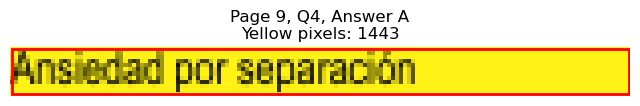

Page 9, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=112.0, y1=354.7
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 222
Page 9, Q4, B: Yellow percentage: 0.0%


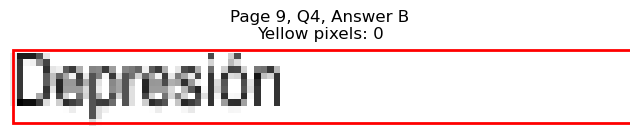

Page 9, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=421.8, y1=342.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 504
Page 9, Q4, C: Yellow percentage: 0.0%


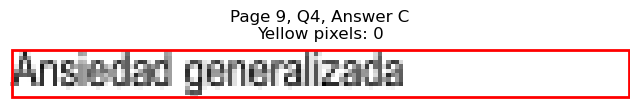

Page 9, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=362.6, y1=354.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 166
Page 9, Q4, D: Yellow percentage: 0.0%


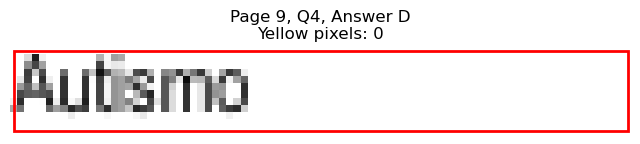


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=112.4, y1=405.1
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 230
Page 9, Q5, A: Yellow percentage: 0.0%


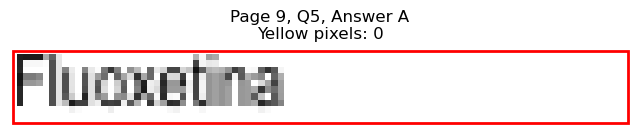

Page 9, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=109.4, y1=417.7
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 223
Page 9, Q5, B: Yellow percentage: 0.0%


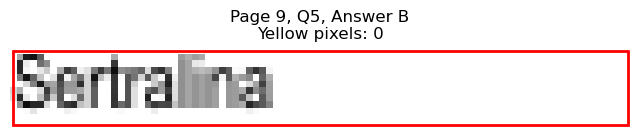

Page 9, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=373.6, y1=405.1
Page 9, Q5, C: Yellow pixels: 888
Page 9, Q5, C: Total non-white pixels: 1069
Page 9, Q5, C: Yellow percentage: 83.1%


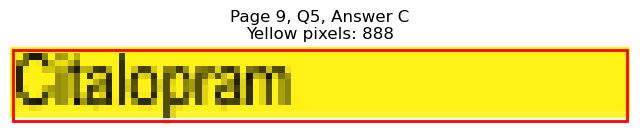

Page 9, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=373.1, y1=417.7
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 227
Page 9, Q5, D: Yellow percentage: 0.0%


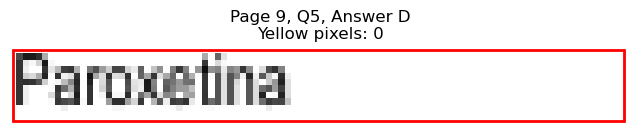


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=158.5, y1=493.5
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 468
Page 9, Q6, A: Yellow percentage: 0.0%


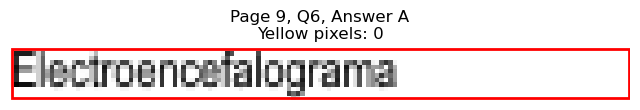

Page 9, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=152.0, y1=506.1
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 399
Page 9, Q6, B: Yellow percentage: 0.0%


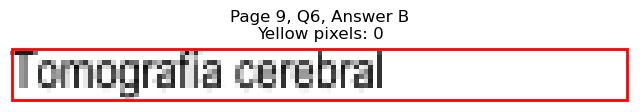

Page 9, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=382.7, y1=493.5
Page 9, Q6, C: Yellow pixels: 941
Page 9, Q6, C: Total non-white pixels: 1272
Page 9, Q6, C: Yellow percentage: 74.0%


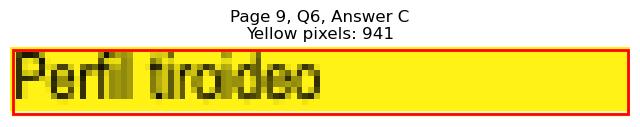

Page 9, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=391.7, y1=506.1
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 328
Page 9, Q6, D: Yellow percentage: 0.0%


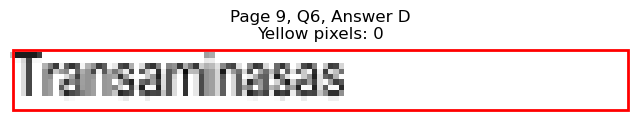


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=108.4, y1=556.5
Page 9, Q7, A: Yellow pixels: 91
Page 9, Q7, A: Total non-white pixels: 311
Page 9, Q7, A: Yellow percentage: 29.3%


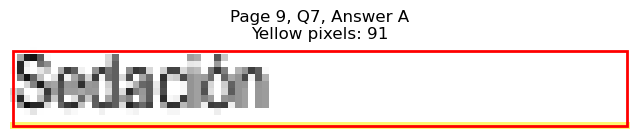

Page 9, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=124.4, y1=569.2
Page 9, Q7, B: Yellow pixels: 965
Page 9, Q7, B: Total non-white pixels: 1177
Page 9, Q7, B: Yellow percentage: 82.0%


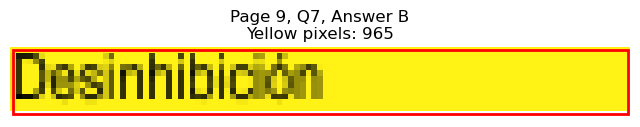

Page 9, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=366.6, y1=556.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 194
Page 9, Q7, C: Yellow percentage: 0.0%


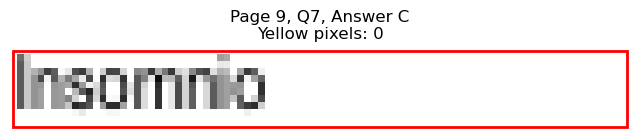

Page 9, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=361.6, y1=569.2
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 180
Page 9, Q7, D: Yellow percentage: 0.0%


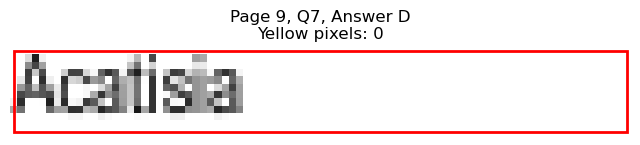


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=114.4, y1=619.6
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 244
Page 9, Q8, A: Yellow percentage: 0.0%


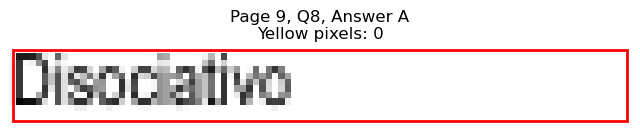

Page 9, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=100.4, y1=632.4
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 153
Page 9, Q8, B: Yellow percentage: 0.0%


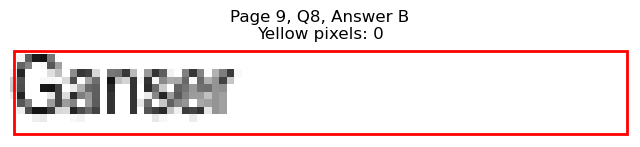

Page 9, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=361.1, y1=619.6
Page 9, Q8, C: Yellow pixels: 891
Page 9, Q8, C: Total non-white pixels: 1020
Page 9, Q8, C: Yellow percentage: 87.4%


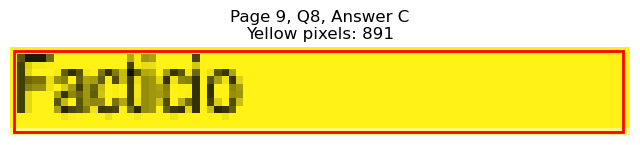

Page 9, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=364.1, y1=632.4
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 191
Page 9, Q8, D: Yellow percentage: 0.0%


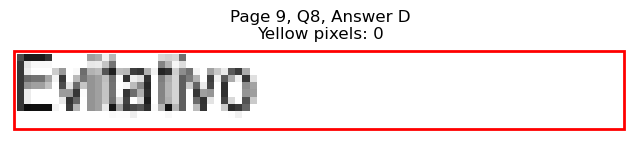


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=104.9, y1=682.8
Page 9, Q9, A: Yellow pixels: 87
Page 9, Q9, A: Total non-white pixels: 242
Page 9, Q9, A: Yellow percentage: 36.0%


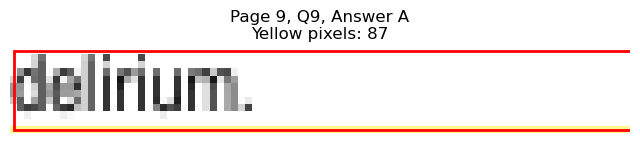

Page 9, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=115.9, y1=695.4
Page 9, Q9, B: Yellow pixels: 906
Page 9, Q9, B: Total non-white pixels: 1176
Page 9, Q9, B: Yellow percentage: 77.0%


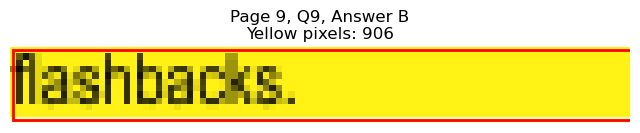

Page 9, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=366.1, y1=682.8
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 178
Page 9, Q9, C: Yellow percentage: 0.0%


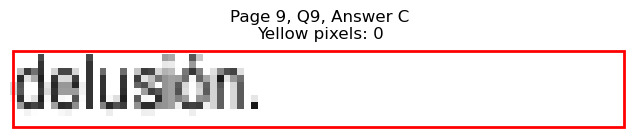

Page 9, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=387.1, y1=695.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 289
Page 9, Q9, D: Yellow percentage: 0.0%


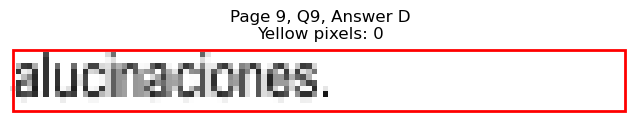


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=734.8, x1=101.4, y1=745.9
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 170
Page 9, Q10, A: Yellow percentage: 0.0%


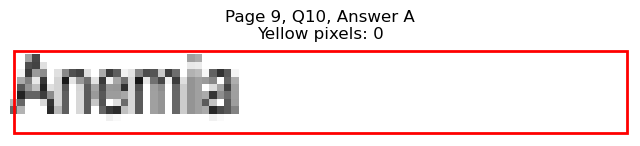

Page 9, Q10 - B: Detected box: x0=68.3, y0=747.4, x1=98.9, y1=758.5
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 163
Page 9, Q10, B: Yellow percentage: 0.0%


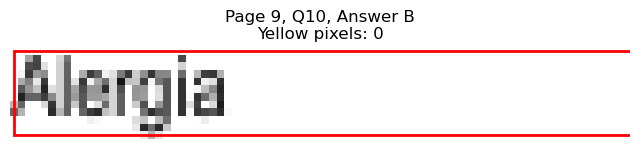

Page 9, Q10 - C: Detected box: x0=327.5, y0=734.8, x1=347.5, y1=745.9
Page 9, Q10, C: Yellow pixels: 784
Page 9, Q10, C: Total non-white pixels: 852
Page 9, Q10, C: Yellow percentage: 92.0%


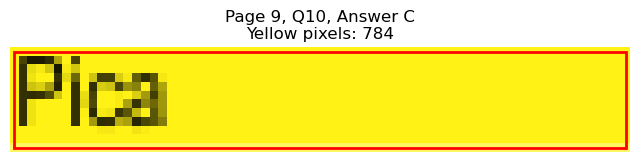

Page 9, Q10 - D: Detected box: x0=327.5, y0=747.4, x1=369.6, y1=758.5
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 215
Page 9, Q10, D: Yellow percentage: 0.0%


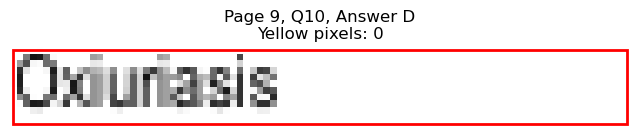


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 6 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=113.4, y1=114.8
Page 10, Q1, A: Yellow pixels: 96
Page 10, Q1, A: Total non-white pixels: 340
Page 10, Q1, A: Yellow percentage: 28.2%


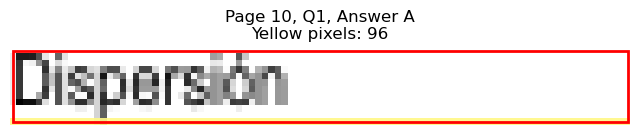

Page 10, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=103.9, y1=127.4
Page 10, Q1, B: Yellow pixels: 808
Page 10, Q1, B: Total non-white pixels: 1032
Page 10, Q1, B: Yellow percentage: 78.3%


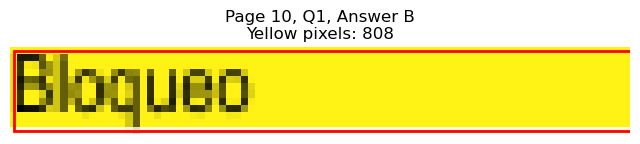

Page 10, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=377.6, y1=114.8
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 265
Page 10, Q1, C: Yellow percentage: 0.0%


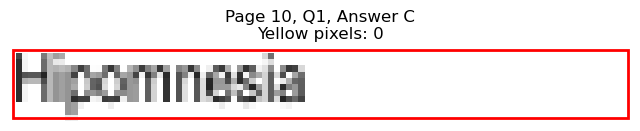

Page 10, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=373.1, y1=127.4
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 243
Page 10, Q1, D: Yellow percentage: 0.0%


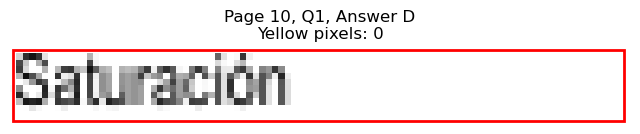


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=162.6, y1=190.5
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 497
Page 10, Q2, A: Yellow percentage: 0.0%


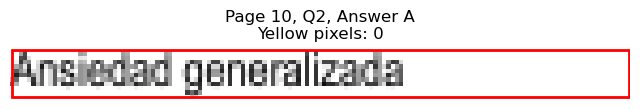

Page 10, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=98.4, y1=203.1
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 158
Page 10, Q2, B: Yellow percentage: 0.0%


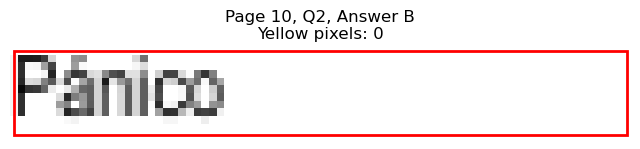

Page 10, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=358.1, y1=190.5
Page 10, Q2, C: Yellow pixels: 82
Page 10, Q2, C: Total non-white pixels: 228
Page 10, Q2, C: Yellow percentage: 36.0%


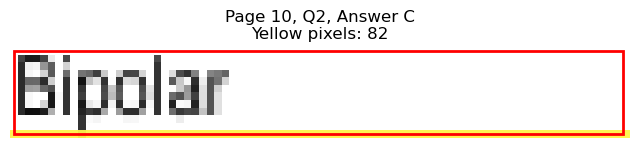

Page 10, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=408.7, y1=203.1
Page 10, Q2, D: Yellow pixels: 1139
Page 10, Q2, D: Total non-white pixels: 1453
Page 10, Q2, D: Yellow percentage: 78.4%


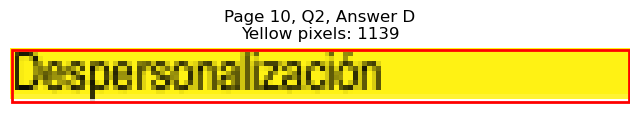


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=116.4, y1=241.0
Page 10, Q3, A: Yellow pixels: 99
Page 10, Q3, A: Total non-white pixels: 464
Page 10, Q3, A: Yellow percentage: 21.3%


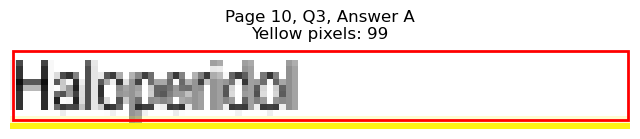

Page 10, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=116.4, y1=253.6
Page 10, Q3, B: Yellow pixels: 883
Page 10, Q3, B: Total non-white pixels: 1188
Page 10, Q3, B: Yellow percentage: 74.3%


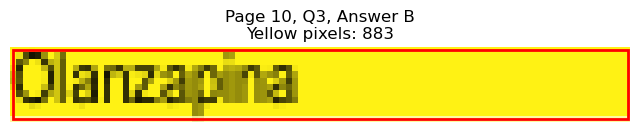

Page 10, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=374.2, y1=241.0
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 245
Page 10, Q3, C: Yellow percentage: 0.0%


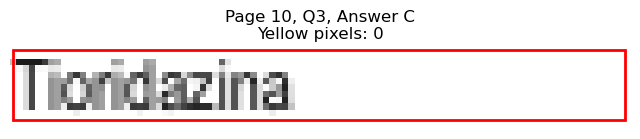

Page 10, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=387.1, y1=253.6
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 302
Page 10, Q3, D: Yellow percentage: 0.0%


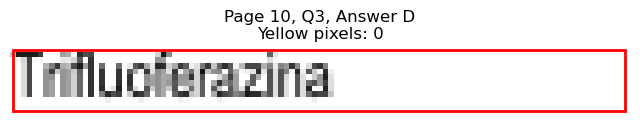


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=127.4, y1=304.2
Page 10, Q4, A: Yellow pixels: 943
Page 10, Q4, A: Total non-white pixels: 1210
Page 10, Q4, A: Yellow percentage: 77.9%


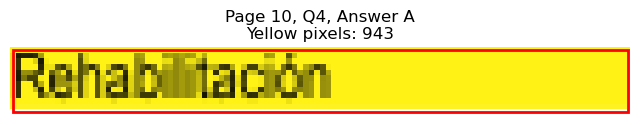

Page 10, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=115.9, y1=316.8
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 231
Page 10, Q4, B: Yellow percentage: 0.0%


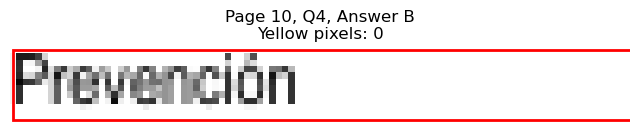

Page 10, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=377.2, y1=304.2
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 283
Page 10, Q4, C: Yellow percentage: 0.0%


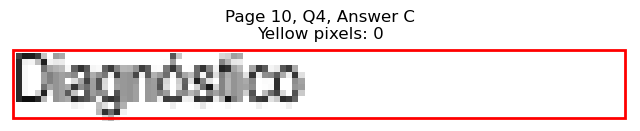

Page 10, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=390.7, y1=316.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 310
Page 10, Q4, D: Yellow percentage: 0.0%


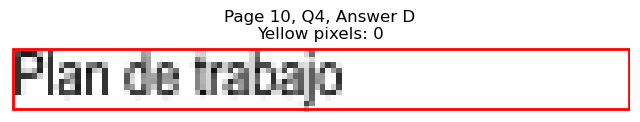


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=108.4, y1=379.9
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 210
Page 10, Q5, A: Yellow percentage: 0.0%


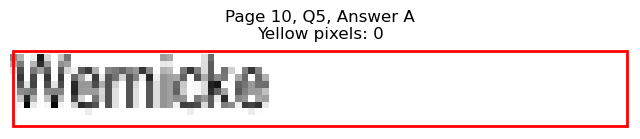

Page 10, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=100.4, y1=392.5
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 153
Page 10, Q5, B: Yellow percentage: 0.0%


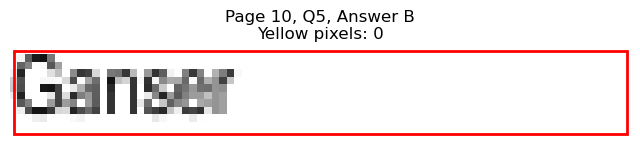

Page 10, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=368.2, y1=379.9
Page 10, Q5, C: Yellow pixels: 941
Page 10, Q5, C: Total non-white pixels: 1104
Page 10, Q5, C: Yellow percentage: 85.2%


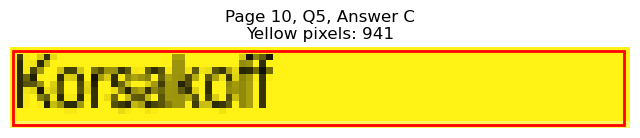

Page 10, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=364.7, y1=392.5
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 165
Page 10, Q5, D: Yellow percentage: 0.0%


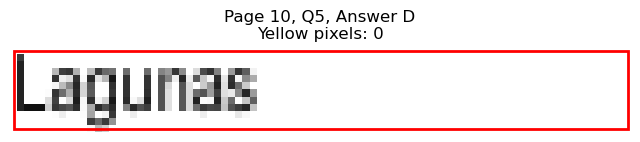


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=113.4, y1=443.0
Page 10, Q6, A: Yellow pixels: 986
Page 10, Q6, A: Total non-white pixels: 1152
Page 10, Q6, A: Yellow percentage: 85.6%


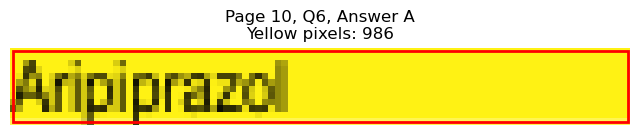

Page 10, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=116.4, y1=455.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 270
Page 10, Q6, B: Yellow percentage: 0.0%


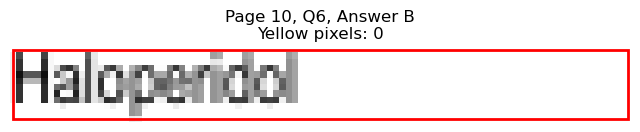

Page 10, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=389.6, y1=443.0
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 309
Page 10, Q6, C: Yellow percentage: 0.0%


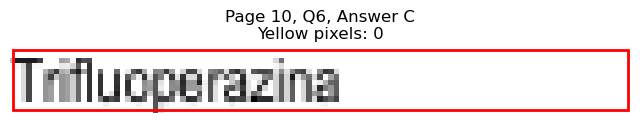

Page 10, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=369.2, y1=455.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 234
Page 10, Q6, D: Yellow percentage: 0.0%


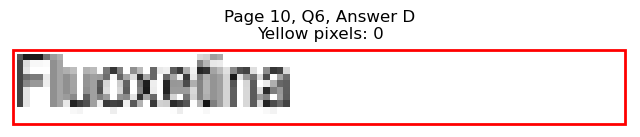


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Hasta cuántos días se puede detectar los meta...
1   Mujer de 32 años, denunciada por golpear a las...
2   En la esquizofrenia. ¿Cuál es el complejo sint...
3   ¿Cómo se llama al aspecto psicosocial y experi...
4   Mujer de 38 años, ingeniera civil, que debe su...
..                                                ...
95  Mujer de 27 años; se queja de episodios interm...
96  ¿Cuál de los siguientes es un antipsicótico de...
97  Comprende intervenciones diseñadas para ayudar...
98  Rafael de 45 años, con antecedentes de consumo...
99  ¿Cuál es el antipsicótico antagonista de los r...

[100 rows x 1 columns]

In [8]:
answers_df

option_A               option_B               option_C  \
0                       7                     14                     21   
1      Narcisismo maligno  Personalidad disocial  Indiferencia afectiva   
2              Hebefrenia              Limítrofe               Escisión   
3               Identidad             Asignación            Congruencia   
4        Realidad virtual            De esquemas              Sistémica   
..                    ...                    ...                    ...   
95  Ansiedad generalizada                 Pánico                Bipolar   
96            Haloperidol             Olanzapina            Tioridazina   
97         Rehabilitación             Prevención            Diagnóstico   
98               Wernicke                 Ganser              Korsakoff   
99            Aripiprazol            Haloperidol        Trifluoperazina   

               option_D  
0                    28  
1   Control de impulsos  
2              Catéxica  
3                Género  
4         Psicodinámica  
..                  ...  
95   Despersonalización  
96      Trifluoferazina  
97      Plan de trabajo  
98              Lagunas  
99           Fluoxetina  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions               option_A  \
0   ¿Hasta cuántos días se puede detectar los meta...                      7   
1   Mujer de 32 años, denunciada por golpear a las...     Narcisismo maligno   
2   En la esquizofrenia. ¿Cuál es el complejo sint...             Hebefrenia   
3   ¿Cómo se llama al aspecto psicosocial y experi...              Identidad   
4   Mujer de 38 años, ingeniera civil, que debe su...       Realidad virtual   
..                                                ...                    ...   
95  Mujer de 27 años; se queja de episodios interm...  Ansiedad generalizada   
96  ¿Cuál de los siguientes es un antipsicótico de...            Haloperidol   
97  Comprende intervenciones diseñadas para ayudar...         Rehabilitación   
98  Rafael de 45 años, con antecedentes de consumo...               Wernicke   
99  ¿Cuál es el antipsicótico antagonista de los r...            Aripiprazol   

                 option_B               option_C             option_D  \
0                      14                     21                   28   
1   Personalidad disocial  Indiferencia afectiva  Control de impulsos   
2               Limítrofe               Escisión             Catéxica   
3              Asignación            Congruencia               Género   
4             De esquemas              Sistémica        Psicodinámica   
..                    ...                    ...                  ...   
95                 Pánico                Bipolar   Despersonalización   
96             Olanzapina            Tioridazina      Trifluoferazina   
97             Prevención            Diagnóstico      Plan de trabajo   
98                 Ganser              Korsakoff              Lagunas   
99            Haloperidol        Trifluoperazina           Fluoxetina   

   correct_answer  
0               A  
1               B  
2               A  
3               D  
4               A  
..            ...  
95              D  
96              B  
97              A  
98              C  
99              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/PSIQUIATRIA.csv
